# Face Recognition
**Attempt-2**: 

Build model to recognize own faces

Custom dataset of 10 Bollywood start face images (25 images per person) are  collected and trained using InceptionResnetV1 network.


In [ ]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch

# check the allocation manhine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session4/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session4/notebooks


In [ ]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [ ]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.6"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.6


In [ ]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [ ]:
import shutil
#shutil.rmtree('./logs_v2')

In [ ]:
from pathlib import Path

# important folders used in this application

SOLUTION_LOG_DIR = "logs_bws"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [ ]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=16,
    num_workers=6,
    epochs=500,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False, 
    load_model_path = Path(f'./logs/saved_models/ep1_testloss_1.322092000.pth'), # used when resume_training is True
    #load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [ ]:
# dataset root folder
root_dataset = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session4/bollywood_stars/'

In [ ]:
import shutil
#shutil.rmtree(root_dataset)

In [ ]:
ibs_class_names = ['Akshay_Kumar', 'Amitabh_Bachchan', 'Amrish_Puri', 'Anil_Kapoor', 'Kajol', 'Katrina_Kaif', 'Madhuri_Dixit', 'Rajesh_Khanna', 'Shilpa_Shetty', 'Vinod_Khanna']
ibs_class_shortname = ['Akshya', 'Amitabh', 'Amrish', 'Anil', 'Kajol', 'Katrina', 'Madhuri', 'Rajesh', 'Shilpa', 'Vinod']

def display_classnames(shortname_list, fullname_list):
  for shortname, fullname in zip(shortname_list, fullname_list):
    print(f'{shortname}: {fullname}') 

## Preparing Dataset

In [ ]:
import utils.data_utils as dutils

In [ ]:
# check the custom dataset summary added to the original dataset
dutils.get_dataset_count(root_dataset, ibs_class_names)

Akshay_Kumar: 25 images
Amitabh_Bachchan: 25 images
Amrish_Puri: 25 images
Anil_Kapoor: 25 images
Kajol: 25 images
Katrina_Kaif: 25 images
Madhuri_Dixit: 25 images
Rajesh_Khanna: 25 images
Shilpa_Shetty: 25 images
Vinod_Khanna: 25 images

Total images: 250


# Prepare Data Transforms and DataLoader

In [ ]:
from utils.ImageAugmentationUtils import AlbumImageAugmentation
from utils.ImageAugmentationUtils import PyTorchImageAugmentation

means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

imgAugmentation = AlbumImageAugmentation(means, stds, size=224)
#imgAugmentation = PyTorchImageAugmentation(means, stds, size=224)

train_transforms = imgAugmentation.get_train_transform()
test_transforms = imgAugmentation.get_test_transform()

In [ ]:
dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)

train_loader, test_loader = dutils.prepare_dataloader(datadir=root_dataset, 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args, 
                                               valid_size=0.30)


class_names = train_loader.dataset.classes
num_classes = len(class_names)
print(f'\nNum of classes: {num_classes}\nClasses: {class_names}\n')



Total data: 250

Training size: 175
Testing size: 75

Num of classes: 10
Classes: ['Akshay_Kumar', 'Amitabh_Bachchan', 'Amrish_Puri', 'Anil_Kapoor', 'Kajol', 'Katrina_Kaif', 'Madhuri_Dixit', 'Rajesh_Khanna', 'Shilpa_Shetty', 'Vinod_Khanna']



# Visualize few training images

In [ ]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, class_names, means, stds)

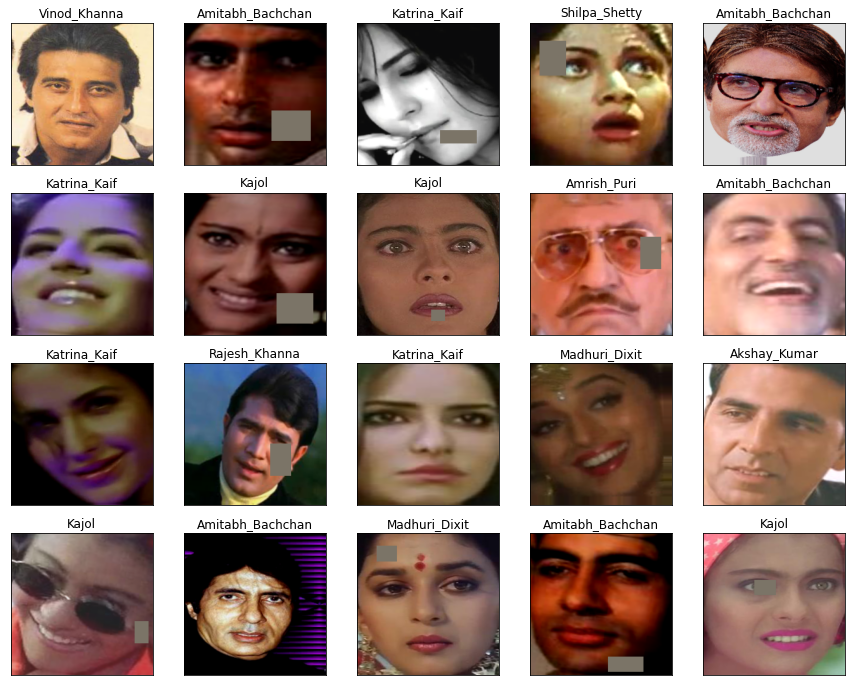

In [ ]:
# visualize how image aumentation is applied on few training dataset images: 
#display_classnames(class_shortname, class_names)
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

In [ ]:
%time
samples = next(iter(train_loader))

# Image dimension
print(f'Image size: {samples[0][0].shape}')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
Image size: torch.Size([3, 224, 224])


# Pretrained InceptionResnetV1 network

In [ ]:
# load pre-training model
from fr_models.inception_resnet_v1 import InceptionResnetV1
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=len(class_names))

In [ ]:
# view last few layesr to find out layesr we need to chnage and unfreeze
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [ ]:
# Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
# Put all beginning layers in an nn.Sequential . model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

# training just final layers
for param in model_ft.parameters():
    param.requires_grad = False

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
# apply the final layers back to the new Sequential model. these layers will be trained
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(512, 3)
#model_ft.softmax = nn.Softmax(dim=1)

In [ ]:
from torchsummary import summary
model_name = "InceptionResnetV1_FaceRec"
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,224,224))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FRConvNetwork(nn.Module):
    def __init__(self, loaded_lodel, num_classes=10):
        super(FRConvNetwork, self).__init__()
        self.convlayers = loaded_lodel
        self.fc_final = nn.Linear(3, num_classes)

    def forward(self, x, embed=False):
        x = self.convlayers(x)
        if embed:
            return x
        x = self.fc_final(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [ ]:
from torchsummary import summary
model_name = "InceptionResnetV1_FaceRec"
model = FRConvNetwork(model_ft).to(device)
summary(model, input_size=(3,224,224))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

## LR Finder

The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=400, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


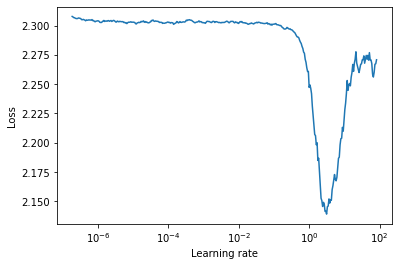

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()

In [ ]:
# To restore the model and optimizer to their initial state
lr_finder.reset()

'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=200, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


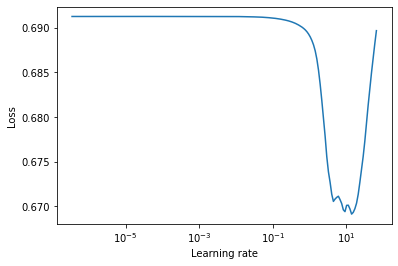

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

## Face Recognition Model

In [ ]:
model_name = "InceptionResnetV1_FaceRec"
model = FRConvNetwork(model_ft).to(device)

In [ ]:
import numpy as np
import torch.nn.functional as F

# fxn to get embedding vector of size 3.. pls note we have configured vector of size 3 in CNN network
def get_embedding(device, model, loader, num_samples=100):
    model = model.to(device).eval()
    full_embeds = []
    full_labels = []
    with torch.no_grad():
        for i, (data, labels) in enumerate(loader):
            data = data[:num_samples].to(device) #
            full_labels.append(labels[:num_samples].cpu().detach().numpy())
            embeds = model(data, embed=True)
            full_embeds.append(F.normalize(embeds.detach().cpu()).numpy())
    model = model.cpu()
    return np.concatenate(full_embeds), np.concatenate(full_labels)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Fucntion to plot Embedding Vectors for each images to visulize how people are segrregated. Here embedding vector size is 3
def plot_embedding(embeds, labels, save_filename=None):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a sphere
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='w', alpha=0.3, linewidth=0)
    ax.scatter(embeds[:,0], embeds[:,1], embeds[:,2], c=labels, s=20)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    #ax.set_aspect("equal")
    plt.tight_layout()
    if save_filename:
      fig.savefig(save_filename)

## Build and train model

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 0.015  # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 12 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val) 
#optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)
#lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

# reduce LR when modle get stuck in plateu region
#reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

In [ ]:
from utils.model_utils import ModelUtils
mutils = ModelUtils(model, 
                    device, 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    start_epoch = start_epoch,
                    epochs=EPOCHS,
                    criterion=criterion, 
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    lr_update_ty=config_params['lr_update_ty'],
                    reduceLr_scheduler=None,
                    saved_model_dir=SAVED_MODELS_DIR,
                    tqdm_status=True)

In [ ]:
m_history = mutils.build()

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1 TRAIN ==> [Batch=11] train_loss=2.303198 train_acc: 9.71 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 1 TEST  ==> [Batch=5] test_loss=2.302585 test_acc: 10.67: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2 TRAIN ==> [Batch=11] train_loss=2.302858 train_acc: 9.71 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 2 TEST  ==> [Batch=5] test_loss=2.302447 test_acc: 10.67: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3 TRAIN ==> [Batch=11] train_loss=2.302229 train_acc: 9.71 LR=0.029166667: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 3 TEST  ==> [Batch=5] test_loss=2.301491 test_acc: 10.67: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4 TRAIN ==> [Batch=11] train_loss=2.301270 train_acc: 9.71 LR=0.036250000: 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 4 TEST  ==> [Batch=5] test_loss=2.300693 test_acc: 10.67: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5 TRAIN ==> [Batch=11] train_loss=2.300464 train_acc: 11.43 LR=0.043333333: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 5 TEST  ==> [Batch=5] test_loss=2.299989 test_acc: 13.33: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 6 TRAIN ==> [Batch=11] train_loss=2.298869 train_acc: 17.14 LR=0.050416667: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 6 TEST  ==> [Batch=5] test_loss=2.299640 test_acc: 16.00: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 7 TRAIN ==> [Batch=11] train_loss=2.297466 train_acc: 22.86 LR=0.057500000: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 7 TEST  ==> [Batch=5] test_loss=2.297710 test_acc: 17.33: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 8 TRAIN ==> [Batch=11] train_loss=2.295848 train_acc: 23.43 LR=0.064583333: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 8 TEST  ==> [Batch=5] test_loss=2.297181 test_acc: 21.33: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9 TRAIN ==> [Batch=11] train_loss=2.293386 train_acc: 29.14 LR=0.071666667: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 9 TEST  ==> [Batch=5] test_loss=2.295276 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10 TRAIN ==> [Batch=11] train_loss=2.291120 train_acc: 28.57 LR=0.078750000: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 10 TEST  ==> [Batch=5] test_loss=2.292270 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11 TRAIN ==> [Batch=11] train_loss=2.288378 train_acc: 28.00 LR=0.085833333: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 11 TEST  ==> [Batch=5] test_loss=2.289493 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12 TRAIN ==> [Batch=11] train_loss=2.284074 train_acc: 26.86 LR=0.092916667: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 12 TEST  ==> [Batch=5] test_loss=2.285480 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13 TRAIN ==> [Batch=11] train_loss=2.278332 train_acc: 26.29 LR=0.100000000: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 13 TEST  ==> [Batch=5] test_loss=2.279079 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14 TRAIN ==> [Batch=11] train_loss=2.272548 train_acc: 25.14 LR=0.092916667: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 14 TEST  ==> [Batch=5] test_loss=2.273950 test_acc: 21.33: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 15 TRAIN ==> [Batch=11] train_loss=2.262265 train_acc: 27.43 LR=0.085833333: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 15 TEST  ==> [Batch=5] test_loss=2.266557 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 16 TRAIN ==> [Batch=11] train_loss=2.248034 train_acc: 28.57 LR=0.078750000: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 16 TEST  ==> [Batch=5] test_loss=2.251439 test_acc: 21.33: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17 TRAIN ==> [Batch=11] train_loss=2.237783 train_acc: 26.29 LR=0.071666667: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 17 TEST  ==> [Batch=5] test_loss=2.238461 test_acc: 22.67: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 18 TRAIN ==> [Batch=11] train_loss=2.226130 train_acc: 27.43 LR=0.064583333: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 18 TEST  ==> [Batch=5] test_loss=2.225542 test_acc: 24.00: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 19 TRAIN ==> [Batch=11] train_loss=2.216112 train_acc: 25.14 LR=0.057500000: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 19 TEST  ==> [Batch=5] test_loss=2.224624 test_acc: 25.33: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 20 TRAIN ==> [Batch=11] train_loss=2.205550 train_acc: 25.71 LR=0.050416667: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 20 TEST  ==> [Batch=5] test_loss=2.211860 test_acc: 25.33: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 21 TRAIN ==> [Batch=11] train_loss=2.190648 train_acc: 28.00 LR=0.043333333: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 21 TEST  ==> [Batch=5] test_loss=2.209702 test_acc: 26.67: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 22 TRAIN ==> [Batch=11] train_loss=2.184475 train_acc: 27.43 LR=0.036250000: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 22 TEST  ==> [Batch=5] test_loss=2.201768 test_acc: 26.67: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 23 TRAIN ==> [Batch=11] train_loss=2.184451 train_acc: 28.57 LR=0.029166667: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 23 TEST  ==> [Batch=5] test_loss=2.188507 test_acc: 28.00: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 24 TRAIN ==> [Batch=11] train_loss=2.173208 train_acc: 28.57 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 24 TEST  ==> [Batch=5] test_loss=2.188266 test_acc: 28.00: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 25 TRAIN ==> [Batch=11] train_loss=2.165534 train_acc: 30.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 25 TEST  ==> [Batch=5] test_loss=2.189092 test_acc: 28.00: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 26 TRAIN ==> [Batch=11] train_loss=2.164366 train_acc: 29.14 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 26 TEST  ==> [Batch=5] test_loss=2.185388 test_acc: 29.33: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 27 TRAIN ==> [Batch=11] train_loss=2.156732 train_acc: 30.29 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 27 TEST  ==> [Batch=5] test_loss=2.181763 test_acc: 28.00: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 28 TRAIN ==> [Batch=11] train_loss=2.152710 train_acc: 30.86 LR=0.025625000: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 28 TEST  ==> [Batch=5] test_loss=2.171319 test_acc: 29.33: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 29 TRAIN ==> [Batch=11] train_loss=2.139651 train_acc: 32.00 LR=0.029166667: 100%|██████████| 11/11 [00:03<00:00,  3.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 29 TEST  ==> [Batch=5] test_loss=2.168503 test_acc: 32.00: 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 30 TRAIN ==> [Batch=11] train_loss=2.126030 train_acc: 32.57 LR=0.032708333: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 30 TEST  ==> [Batch=5] test_loss=2.150960 test_acc: 32.00: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 31 TRAIN ==> [Batch=11] train_loss=2.115126 train_acc: 35.43 LR=0.036250000: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 31 TEST  ==> [Batch=5] test_loss=2.143480 test_acc: 32.00: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 32 TRAIN ==> [Batch=11] train_loss=2.106890 train_acc: 37.14 LR=0.039791667: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 32 TEST  ==> [Batch=5] test_loss=2.125707 test_acc: 32.00: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 33 TRAIN ==> [Batch=11] train_loss=2.084169 train_acc: 42.29 LR=0.043333333: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 33 TEST  ==> [Batch=5] test_loss=2.122260 test_acc: 37.33: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 34 TRAIN ==> [Batch=11] train_loss=2.072073 train_acc: 45.14 LR=0.046875000: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 34 TEST  ==> [Batch=5] test_loss=2.108189 test_acc: 36.00: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 35 TRAIN ==> [Batch=11] train_loss=2.039794 train_acc: 45.14 LR=0.050416667: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 35 TEST  ==> [Batch=5] test_loss=2.098244 test_acc: 33.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 36 TRAIN ==> [Batch=11] train_loss=2.022019 train_acc: 49.14 LR=0.053958333: 100%|██████████| 11/11 [00:03<00:00,  3.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 36 TEST  ==> [Batch=5] test_loss=2.087793 test_acc: 36.00: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 37 TRAIN ==> [Batch=11] train_loss=2.002226 train_acc: 50.29 LR=0.057500000: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 37 TEST  ==> [Batch=5] test_loss=2.083921 test_acc: 38.67: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 38 TRAIN ==> [Batch=11] train_loss=2.005790 train_acc: 47.43 LR=0.053958333: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 38 TEST  ==> [Batch=5] test_loss=2.082720 test_acc: 40.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 39 TRAIN ==> [Batch=11] train_loss=1.995164 train_acc: 48.57 LR=0.050416667: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 39 TEST  ==> [Batch=5] test_loss=2.089439 test_acc: 37.33: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 40 TRAIN ==> [Batch=11] train_loss=1.968329 train_acc: 51.43 LR=0.046875000: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 40 TEST  ==> [Batch=5] test_loss=2.056799 test_acc: 41.33: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 41 TRAIN ==> [Batch=11] train_loss=1.991138 train_acc: 50.86 LR=0.043333333: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 41 TEST  ==> [Batch=5] test_loss=2.069834 test_acc: 36.00: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 42 TRAIN ==> [Batch=11] train_loss=1.956347 train_acc: 51.43 LR=0.039791667: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 42 TEST  ==> [Batch=5] test_loss=2.060796 test_acc: 38.67: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 43 TRAIN ==> [Batch=11] train_loss=1.937275 train_acc: 54.86 LR=0.036250000: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 43 TEST  ==> [Batch=5] test_loss=2.053777 test_acc: 40.00: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 44 TRAIN ==> [Batch=11] train_loss=1.956884 train_acc: 50.29 LR=0.032708333: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 44 TEST  ==> [Batch=5] test_loss=2.064448 test_acc: 40.00: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 45 TRAIN ==> [Batch=11] train_loss=1.934571 train_acc: 56.57 LR=0.029166667: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 45 TEST  ==> [Batch=5] test_loss=2.043653 test_acc: 41.33: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 46 TRAIN ==> [Batch=11] train_loss=1.953723 train_acc: 54.86 LR=0.025625000: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 46 TEST  ==> [Batch=5] test_loss=2.126629 test_acc: 33.33: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 47 TRAIN ==> [Batch=11] train_loss=1.916250 train_acc: 60.00 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 47 TEST  ==> [Batch=5] test_loss=2.052084 test_acc: 41.33: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 48 TRAIN ==> [Batch=11] train_loss=1.903069 train_acc: 60.57 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 48 TEST  ==> [Batch=5] test_loss=2.040926 test_acc: 44.00: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 49 TRAIN ==> [Batch=11] train_loss=1.892734 train_acc: 63.43 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 49 TEST  ==> [Batch=5] test_loss=2.028733 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 50 TRAIN ==> [Batch=11] train_loss=1.897603 train_acc: 61.14 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 50 TEST  ==> [Batch=5] test_loss=1.999619 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 51 TRAIN ==> [Batch=11] train_loss=1.902407 train_acc: 60.00 LR=0.018541667: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 51 TEST  ==> [Batch=5] test_loss=1.997829 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 52 TRAIN ==> [Batch=11] train_loss=1.890604 train_acc: 61.14 LR=0.020312500: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 52 TEST  ==> [Batch=5] test_loss=2.023098 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 53 TRAIN ==> [Batch=11] train_loss=1.905214 train_acc: 59.43 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 53 TEST  ==> [Batch=5] test_loss=1.989083 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 54 TRAIN ==> [Batch=11] train_loss=1.886992 train_acc: 61.14 LR=0.023854167: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 54 TEST  ==> [Batch=5] test_loss=2.009700 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 55 TRAIN ==> [Batch=11] train_loss=1.877011 train_acc: 61.71 LR=0.025625000: 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 55 TEST  ==> [Batch=5] test_loss=1.989777 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 56 TRAIN ==> [Batch=11] train_loss=1.860890 train_acc: 63.43 LR=0.027395833: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 56 TEST  ==> [Batch=5] test_loss=2.002615 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 57 TRAIN ==> [Batch=11] train_loss=1.876169 train_acc: 61.14 LR=0.029166667: 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 57 TEST  ==> [Batch=5] test_loss=1.995579 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 58 TRAIN ==> [Batch=11] train_loss=1.900519 train_acc: 56.57 LR=0.030937500: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 58 TEST  ==> [Batch=5] test_loss=1.995107 test_acc: 45.33: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 59 TRAIN ==> [Batch=11] train_loss=1.886364 train_acc: 60.00 LR=0.032708333: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 59 TEST  ==> [Batch=5] test_loss=1.992928 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 60 TRAIN ==> [Batch=11] train_loss=1.851186 train_acc: 62.86 LR=0.034479167: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 60 TEST  ==> [Batch=5] test_loss=1.993330 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 61 TRAIN ==> [Batch=11] train_loss=1.875005 train_acc: 59.43 LR=0.036250000: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 61 TEST  ==> [Batch=5] test_loss=1.994353 test_acc: 45.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 62 TRAIN ==> [Batch=11] train_loss=1.883718 train_acc: 57.14 LR=0.034479167: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 62 TEST  ==> [Batch=5] test_loss=1.995835 test_acc: 44.00: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 63 TRAIN ==> [Batch=11] train_loss=1.858366 train_acc: 61.71 LR=0.032708333: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 63 TEST  ==> [Batch=5] test_loss=1.983695 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 64 TRAIN ==> [Batch=11] train_loss=1.863760 train_acc: 60.57 LR=0.030937500: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 64 TEST  ==> [Batch=5] test_loss=1.970168 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 65 TRAIN ==> [Batch=11] train_loss=1.861668 train_acc: 60.00 LR=0.029166667: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 65 TEST  ==> [Batch=5] test_loss=2.007326 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 66 TRAIN ==> [Batch=11] train_loss=1.862010 train_acc: 61.14 LR=0.027395833: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 66 TEST  ==> [Batch=5] test_loss=2.003224 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 67 TRAIN ==> [Batch=11] train_loss=1.842714 train_acc: 61.14 LR=0.025625000: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 67 TEST  ==> [Batch=5] test_loss=1.998479 test_acc: 45.33: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 68 TRAIN ==> [Batch=11] train_loss=1.834444 train_acc: 63.43 LR=0.023854167: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 68 TEST  ==> [Batch=5] test_loss=1.997338 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 69 TRAIN ==> [Batch=11] train_loss=1.836066 train_acc: 63.43 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 69 TEST  ==> [Batch=5] test_loss=1.986041 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 70 TRAIN ==> [Batch=11] train_loss=1.851245 train_acc: 61.71 LR=0.020312500: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 70 TEST  ==> [Batch=5] test_loss=2.007238 test_acc: 42.67: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 71 TRAIN ==> [Batch=11] train_loss=1.836800 train_acc: 64.00 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 71 TEST  ==> [Batch=5] test_loss=2.004032 test_acc: 45.33: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 72 TRAIN ==> [Batch=11] train_loss=1.830928 train_acc: 63.43 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 72 TEST  ==> [Batch=5] test_loss=1.977415 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 73 TRAIN ==> [Batch=11] train_loss=1.842845 train_acc: 61.71 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 73 TEST  ==> [Batch=5] test_loss=1.982304 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 74 TRAIN ==> [Batch=11] train_loss=1.845316 train_acc: 62.86 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 74 TEST  ==> [Batch=5] test_loss=1.970294 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 75 TRAIN ==> [Batch=11] train_loss=1.835903 train_acc: 62.29 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 75 TEST  ==> [Batch=5] test_loss=1.971264 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 76 TRAIN ==> [Batch=11] train_loss=1.825741 train_acc: 62.86 LR=0.017656250: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 76 TEST  ==> [Batch=5] test_loss=1.978257 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 77 TRAIN ==> [Batch=11] train_loss=1.824466 train_acc: 64.00 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 77 TEST  ==> [Batch=5] test_loss=1.974767 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 78 TRAIN ==> [Batch=11] train_loss=1.830088 train_acc: 64.00 LR=0.019427083: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 78 TEST  ==> [Batch=5] test_loss=1.970255 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 79 TRAIN ==> [Batch=11] train_loss=1.823125 train_acc: 63.43 LR=0.020312500: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 79 TEST  ==> [Batch=5] test_loss=1.964225 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 80 TRAIN ==> [Batch=11] train_loss=1.823838 train_acc: 64.00 LR=0.021197917: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 80 TEST  ==> [Batch=5] test_loss=1.982078 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 81 TRAIN ==> [Batch=11] train_loss=1.823621 train_acc: 63.43 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 81 TEST  ==> [Batch=5] test_loss=1.992516 test_acc: 44.00: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 82 TRAIN ==> [Batch=11] train_loss=1.830139 train_acc: 62.86 LR=0.022968750: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 82 TEST  ==> [Batch=5] test_loss=1.967633 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 83 TRAIN ==> [Batch=11] train_loss=1.831208 train_acc: 62.29 LR=0.023854167: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 83 TEST  ==> [Batch=5] test_loss=1.970010 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 84 TRAIN ==> [Batch=11] train_loss=1.826126 train_acc: 63.43 LR=0.024739583: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 84 TEST  ==> [Batch=5] test_loss=1.981142 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 85 TRAIN ==> [Batch=11] train_loss=1.838439 train_acc: 62.86 LR=0.025625000: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 85 TEST  ==> [Batch=5] test_loss=1.963058 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 86 TRAIN ==> [Batch=11] train_loss=1.833095 train_acc: 61.71 LR=0.024739583: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 86 TEST  ==> [Batch=5] test_loss=1.978095 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 87 TRAIN ==> [Batch=11] train_loss=1.841108 train_acc: 61.14 LR=0.023854167: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 87 TEST  ==> [Batch=5] test_loss=1.956620 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 88 TRAIN ==> [Batch=11] train_loss=1.810332 train_acc: 64.57 LR=0.022968750: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 88 TEST  ==> [Batch=5] test_loss=1.968197 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 89 TRAIN ==> [Batch=11] train_loss=1.826936 train_acc: 62.86 LR=0.022083333: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 89 TEST  ==> [Batch=5] test_loss=1.964004 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 90 TRAIN ==> [Batch=11] train_loss=1.834264 train_acc: 62.86 LR=0.021197917: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 90 TEST  ==> [Batch=5] test_loss=1.944743 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 91 TRAIN ==> [Batch=11] train_loss=1.826421 train_acc: 62.86 LR=0.020312500: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 91 TEST  ==> [Batch=5] test_loss=1.950449 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 92 TRAIN ==> [Batch=11] train_loss=1.808680 train_acc: 64.57 LR=0.019427083: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 92 TEST  ==> [Batch=5] test_loss=1.956907 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 93 TRAIN ==> [Batch=11] train_loss=1.835977 train_acc: 61.71 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 93 TEST  ==> [Batch=5] test_loss=1.969733 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 94 TRAIN ==> [Batch=11] train_loss=1.810722 train_acc: 64.57 LR=0.017656250: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 94 TEST  ==> [Batch=5] test_loss=1.970159 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 95 TRAIN ==> [Batch=11] train_loss=1.820842 train_acc: 62.86 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 95 TEST  ==> [Batch=5] test_loss=1.967906 test_acc: 45.33: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 96 TRAIN ==> [Batch=11] train_loss=1.818569 train_acc: 62.29 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 96 TEST  ==> [Batch=5] test_loss=1.973955 test_acc: 45.33: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 97 TRAIN ==> [Batch=11] train_loss=1.824470 train_acc: 61.14 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 97 TEST  ==> [Batch=5] test_loss=1.946734 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 98 TRAIN ==> [Batch=11] train_loss=1.816038 train_acc: 63.43 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 98 TEST  ==> [Batch=5] test_loss=1.960480 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 99 TRAIN ==> [Batch=11] train_loss=1.811564 train_acc: 64.57 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 99 TEST  ==> [Batch=5] test_loss=1.965456 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 100 TRAIN ==> [Batch=11] train_loss=1.829271 train_acc: 62.29 LR=0.016328125: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 100 TEST  ==> [Batch=5] test_loss=1.965193 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 101 TRAIN ==> [Batch=11] train_loss=1.814714 train_acc: 62.29 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 101 TEST  ==> [Batch=5] test_loss=1.970497 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 102 TRAIN ==> [Batch=11] train_loss=1.814236 train_acc: 62.86 LR=0.017213542: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 102 TEST  ==> [Batch=5] test_loss=1.962235 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 103 TRAIN ==> [Batch=11] train_loss=1.827646 train_acc: 62.29 LR=0.017656250: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 103 TEST  ==> [Batch=5] test_loss=1.975605 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 104 TRAIN ==> [Batch=11] train_loss=1.808238 train_acc: 64.00 LR=0.018098958: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 104 TEST  ==> [Batch=5] test_loss=1.964696 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 105 TRAIN ==> [Batch=11] train_loss=1.801022 train_acc: 64.57 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 105 TEST  ==> [Batch=5] test_loss=1.957446 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 106 TRAIN ==> [Batch=11] train_loss=1.805101 train_acc: 64.57 LR=0.018984375: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 106 TEST  ==> [Batch=5] test_loss=1.940040 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 107 TRAIN ==> [Batch=11] train_loss=1.811006 train_acc: 62.86 LR=0.019427083: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 107 TEST  ==> [Batch=5] test_loss=1.921682 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 108 TRAIN ==> [Batch=11] train_loss=1.801496 train_acc: 64.00 LR=0.019869792: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 108 TEST  ==> [Batch=5] test_loss=1.956919 test_acc: 48.00: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 109 TRAIN ==> [Batch=11] train_loss=1.790347 train_acc: 65.71 LR=0.020312500: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 109 TEST  ==> [Batch=5] test_loss=1.947368 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 110 TRAIN ==> [Batch=11] train_loss=1.794298 train_acc: 66.29 LR=0.019869792: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 110 TEST  ==> [Batch=5] test_loss=1.937078 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 111 TRAIN ==> [Batch=11] train_loss=1.803426 train_acc: 64.57 LR=0.019427083: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 111 TEST  ==> [Batch=5] test_loss=1.937527 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 112 TRAIN ==> [Batch=11] train_loss=1.791457 train_acc: 65.71 LR=0.018984375: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 112 TEST  ==> [Batch=5] test_loss=1.927881 test_acc: 49.33: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 113 TRAIN ==> [Batch=11] train_loss=1.791508 train_acc: 68.00 LR=0.018541667: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 113 TEST  ==> [Batch=5] test_loss=1.922489 test_acc: 52.00: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 114 TRAIN ==> [Batch=11] train_loss=1.790134 train_acc: 65.14 LR=0.018098958: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 114 TEST  ==> [Batch=5] test_loss=1.927952 test_acc: 53.33: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 115 TRAIN ==> [Batch=11] train_loss=1.792484 train_acc: 65.14 LR=0.017656250: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 115 TEST  ==> [Batch=5] test_loss=1.940885 test_acc: 52.00: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 116 TRAIN ==> [Batch=11] train_loss=1.794838 train_acc: 68.00 LR=0.017213542: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 116 TEST  ==> [Batch=5] test_loss=1.931615 test_acc: 53.33: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 117 TRAIN ==> [Batch=11] train_loss=1.786323 train_acc: 69.14 LR=0.016770833: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 117 TEST  ==> [Batch=5] test_loss=1.924671 test_acc: 56.00: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 118 TRAIN ==> [Batch=11] train_loss=1.776557 train_acc: 71.43 LR=0.016328125: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 118 TEST  ==> [Batch=5] test_loss=1.928648 test_acc: 54.67: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 119 TRAIN ==> [Batch=11] train_loss=1.775364 train_acc: 70.29 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 119 TEST  ==> [Batch=5] test_loss=1.912946 test_acc: 60.00: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 120 TRAIN ==> [Batch=11] train_loss=1.785803 train_acc: 71.43 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 120 TEST  ==> [Batch=5] test_loss=1.920238 test_acc: 56.00: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 121 TRAIN ==> [Batch=11] train_loss=1.780463 train_acc: 72.57 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 121 TEST  ==> [Batch=5] test_loss=1.937522 test_acc: 57.33: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 122 TRAIN ==> [Batch=11] train_loss=1.773312 train_acc: 70.29 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 122 TEST  ==> [Batch=5] test_loss=1.901357 test_acc: 58.67: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 123 TRAIN ==> [Batch=11] train_loss=1.767415 train_acc: 73.14 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 123 TEST  ==> [Batch=5] test_loss=1.906859 test_acc: 60.00: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 124 TRAIN ==> [Batch=11] train_loss=1.773891 train_acc: 72.00 LR=0.015664062: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 124 TEST  ==> [Batch=5] test_loss=1.890388 test_acc: 64.00: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 125 TRAIN ==> [Batch=11] train_loss=1.755399 train_acc: 73.14 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 125 TEST  ==> [Batch=5] test_loss=1.887880 test_acc: 64.00: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 126 TRAIN ==> [Batch=11] train_loss=1.763357 train_acc: 73.71 LR=0.016106771: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 126 TEST  ==> [Batch=5] test_loss=1.884120 test_acc: 64.00: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 127 TRAIN ==> [Batch=11] train_loss=1.752272 train_acc: 74.29 LR=0.016328125: 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 127 TEST  ==> [Batch=5] test_loss=1.889082 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 128 TRAIN ==> [Batch=11] train_loss=1.748318 train_acc: 75.43 LR=0.016549479: 100%|██████████| 11/11 [00:02<00:00,  4.56it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 128 TEST  ==> [Batch=5] test_loss=1.892844 test_acc: 60.00: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 129 TRAIN ==> [Batch=11] train_loss=1.741466 train_acc: 76.57 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 129 TEST  ==> [Batch=5] test_loss=1.888473 test_acc: 61.33: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 130 TRAIN ==> [Batch=11] train_loss=1.760726 train_acc: 74.29 LR=0.016992187: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 130 TEST  ==> [Batch=5] test_loss=1.876048 test_acc: 61.33: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 131 TRAIN ==> [Batch=11] train_loss=1.752643 train_acc: 73.71 LR=0.017213542: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 131 TEST  ==> [Batch=5] test_loss=1.869902 test_acc: 61.33: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 132 TRAIN ==> [Batch=11] train_loss=1.735067 train_acc: 74.86 LR=0.017434896: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 132 TEST  ==> [Batch=5] test_loss=1.865569 test_acc: 60.00: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 133 TRAIN ==> [Batch=11] train_loss=1.726882 train_acc: 78.29 LR=0.017656250: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 133 TEST  ==> [Batch=5] test_loss=1.870752 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 134 TRAIN ==> [Batch=11] train_loss=1.708039 train_acc: 80.00 LR=0.017434896: 100%|██████████| 11/11 [00:02<00:00,  4.56it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 134 TEST  ==> [Batch=5] test_loss=1.856518 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 135 TRAIN ==> [Batch=11] train_loss=1.720451 train_acc: 78.29 LR=0.017213542: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 135 TEST  ==> [Batch=5] test_loss=1.879878 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 136 TRAIN ==> [Batch=11] train_loss=1.728665 train_acc: 76.00 LR=0.016992187: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 136 TEST  ==> [Batch=5] test_loss=1.848731 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 137 TRAIN ==> [Batch=11] train_loss=1.742950 train_acc: 75.43 LR=0.016770833: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 137 TEST  ==> [Batch=5] test_loss=1.857701 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 138 TRAIN ==> [Batch=11] train_loss=1.725491 train_acc: 77.14 LR=0.016549479: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 138 TEST  ==> [Batch=5] test_loss=1.830269 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 139 TRAIN ==> [Batch=11] train_loss=1.716863 train_acc: 78.29 LR=0.016328125: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 139 TEST  ==> [Batch=5] test_loss=1.829045 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 140 TRAIN ==> [Batch=11] train_loss=1.726352 train_acc: 78.29 LR=0.016106771: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 140 TEST  ==> [Batch=5] test_loss=1.847002 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 141 TRAIN ==> [Batch=11] train_loss=1.711509 train_acc: 78.86 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 141 TEST  ==> [Batch=5] test_loss=1.830696 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 142 TRAIN ==> [Batch=11] train_loss=1.706188 train_acc: 78.86 LR=0.015664062: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 142 TEST  ==> [Batch=5] test_loss=1.844882 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 143 TRAIN ==> [Batch=11] train_loss=1.711492 train_acc: 76.57 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 143 TEST  ==> [Batch=5] test_loss=1.845735 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 144 TRAIN ==> [Batch=11] train_loss=1.703906 train_acc: 80.00 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 144 TEST  ==> [Batch=5] test_loss=1.815433 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 145 TRAIN ==> [Batch=11] train_loss=1.722280 train_acc: 78.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 145 TEST  ==> [Batch=5] test_loss=1.805905 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 146 TRAIN ==> [Batch=11] train_loss=1.706622 train_acc: 79.43 LR=0.015110677: 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 146 TEST  ==> [Batch=5] test_loss=1.789900 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 147 TRAIN ==> [Batch=11] train_loss=1.698735 train_acc: 78.29 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 147 TEST  ==> [Batch=5] test_loss=1.812950 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 148 TRAIN ==> [Batch=11] train_loss=1.707667 train_acc: 78.29 LR=0.015332031: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 148 TEST  ==> [Batch=5] test_loss=1.804274 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 149 TRAIN ==> [Batch=11] train_loss=1.698672 train_acc: 78.86 LR=0.015442708: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 149 TEST  ==> [Batch=5] test_loss=1.803536 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 150 TRAIN ==> [Batch=11] train_loss=1.708911 train_acc: 78.29 LR=0.015553385: 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 150 TEST  ==> [Batch=5] test_loss=1.826180 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 151 TRAIN ==> [Batch=11] train_loss=1.700726 train_acc: 78.29 LR=0.015664062: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 151 TEST  ==> [Batch=5] test_loss=1.805234 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 152 TRAIN ==> [Batch=11] train_loss=1.688112 train_acc: 80.57 LR=0.015774740: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 152 TEST  ==> [Batch=5] test_loss=1.793327 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 153 TRAIN ==> [Batch=11] train_loss=1.675604 train_acc: 81.71 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 153 TEST  ==> [Batch=5] test_loss=1.793149 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 154 TRAIN ==> [Batch=11] train_loss=1.686405 train_acc: 80.57 LR=0.015996094: 100%|██████████| 11/11 [00:02<00:00,  5.02it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 154 TEST  ==> [Batch=5] test_loss=1.807556 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 155 TRAIN ==> [Batch=11] train_loss=1.694596 train_acc: 79.43 LR=0.016106771: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 155 TEST  ==> [Batch=5] test_loss=1.802045 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 156 TRAIN ==> [Batch=11] train_loss=1.676526 train_acc: 80.57 LR=0.016217448: 100%|██████████| 11/11 [00:02<00:00,  4.48it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 156 TEST  ==> [Batch=5] test_loss=1.816866 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 157 TRAIN ==> [Batch=11] train_loss=1.677845 train_acc: 79.43 LR=0.016328125: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 157 TEST  ==> [Batch=5] test_loss=1.839597 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 158 TRAIN ==> [Batch=11] train_loss=1.712894 train_acc: 77.14 LR=0.016217448: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 158 TEST  ==> [Batch=5] test_loss=1.833337 test_acc: 64.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 159 TRAIN ==> [Batch=11] train_loss=1.673810 train_acc: 80.57 LR=0.016106771: 100%|██████████| 11/11 [00:02<00:00,  4.48it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 159 TEST  ==> [Batch=5] test_loss=1.826406 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 160 TRAIN ==> [Batch=11] train_loss=1.676935 train_acc: 80.57 LR=0.015996094: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 160 TEST  ==> [Batch=5] test_loss=1.820192 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 161 TRAIN ==> [Batch=11] train_loss=1.749410 train_acc: 71.43 LR=0.015885417: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 161 TEST  ==> [Batch=5] test_loss=1.851245 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 162 TRAIN ==> [Batch=11] train_loss=1.707678 train_acc: 77.71 LR=0.015774740: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 162 TEST  ==> [Batch=5] test_loss=1.807667 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 163 TRAIN ==> [Batch=11] train_loss=1.680729 train_acc: 78.86 LR=0.015664062: 100%|██████████| 11/11 [00:02<00:00,  4.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 163 TEST  ==> [Batch=5] test_loss=1.803929 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 164 TRAIN ==> [Batch=11] train_loss=1.692439 train_acc: 78.86 LR=0.015553385: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 164 TEST  ==> [Batch=5] test_loss=1.804208 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 165 TRAIN ==> [Batch=11] train_loss=1.681001 train_acc: 80.00 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 165 TEST  ==> [Batch=5] test_loss=1.805393 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 166 TRAIN ==> [Batch=11] train_loss=1.677879 train_acc: 80.57 LR=0.015332031: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 166 TEST  ==> [Batch=5] test_loss=1.810239 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 167 TRAIN ==> [Batch=11] train_loss=1.687275 train_acc: 77.71 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 167 TEST  ==> [Batch=5] test_loss=1.799018 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 168 TRAIN ==> [Batch=11] train_loss=1.687832 train_acc: 80.00 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 168 TEST  ==> [Batch=5] test_loss=1.789705 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 169 TRAIN ==> [Batch=11] train_loss=1.670716 train_acc: 80.57 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 169 TEST  ==> [Batch=5] test_loss=1.789405 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 170 TRAIN ==> [Batch=11] train_loss=1.739520 train_acc: 72.57 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 170 TEST  ==> [Batch=5] test_loss=1.811130 test_acc: 64.00: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 171 TRAIN ==> [Batch=11] train_loss=1.676562 train_acc: 80.00 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 171 TEST  ==> [Batch=5] test_loss=1.812375 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 172 TRAIN ==> [Batch=11] train_loss=1.697834 train_acc: 78.29 LR=0.015166016: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 172 TEST  ==> [Batch=5] test_loss=1.784053 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 173 TRAIN ==> [Batch=11] train_loss=1.677616 train_acc: 80.00 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 173 TEST  ==> [Batch=5] test_loss=1.796541 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 174 TRAIN ==> [Batch=11] train_loss=1.669328 train_acc: 80.57 LR=0.015276693: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 174 TEST  ==> [Batch=5] test_loss=1.805315 test_acc: 68.00: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 175 TRAIN ==> [Batch=11] train_loss=1.660936 train_acc: 80.00 LR=0.015332031: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 175 TEST  ==> [Batch=5] test_loss=1.767216 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 176 TRAIN ==> [Batch=11] train_loss=1.703033 train_acc: 76.00 LR=0.015387370: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 176 TEST  ==> [Batch=5] test_loss=1.784309 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 177 TRAIN ==> [Batch=11] train_loss=1.704177 train_acc: 78.29 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 177 TEST  ==> [Batch=5] test_loss=1.803970 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 178 TRAIN ==> [Batch=11] train_loss=1.677763 train_acc: 78.29 LR=0.015498047: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 178 TEST  ==> [Batch=5] test_loss=1.796359 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 179 TRAIN ==> [Batch=11] train_loss=1.672318 train_acc: 78.86 LR=0.015553385: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 179 TEST  ==> [Batch=5] test_loss=1.830405 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 180 TRAIN ==> [Batch=11] train_loss=1.698876 train_acc: 77.14 LR=0.015608724: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 180 TEST  ==> [Batch=5] test_loss=1.885229 test_acc: 58.67: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 181 TRAIN ==> [Batch=11] train_loss=1.722238 train_acc: 76.00 LR=0.015664062: 100%|██████████| 11/11 [00:02<00:00,  4.48it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 181 TEST  ==> [Batch=5] test_loss=1.844153 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 182 TRAIN ==> [Batch=11] train_loss=1.677887 train_acc: 78.86 LR=0.015608724: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 182 TEST  ==> [Batch=5] test_loss=1.814205 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 183 TRAIN ==> [Batch=11] train_loss=1.667460 train_acc: 80.00 LR=0.015553385: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 183 TEST  ==> [Batch=5] test_loss=1.780935 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 184 TRAIN ==> [Batch=11] train_loss=1.677976 train_acc: 78.29 LR=0.015498047: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 184 TEST  ==> [Batch=5] test_loss=1.803381 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 185 TRAIN ==> [Batch=11] train_loss=1.667193 train_acc: 79.43 LR=0.015442708: 100%|██████████| 11/11 [00:02<00:00,  5.06it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 185 TEST  ==> [Batch=5] test_loss=1.801230 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 186 TRAIN ==> [Batch=11] train_loss=1.673371 train_acc: 80.00 LR=0.015387370: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 186 TEST  ==> [Batch=5] test_loss=1.793753 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 187 TRAIN ==> [Batch=11] train_loss=1.685178 train_acc: 78.86 LR=0.015332031: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 187 TEST  ==> [Batch=5] test_loss=1.777542 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 188 TRAIN ==> [Batch=11] train_loss=1.661151 train_acc: 80.00 LR=0.015276693: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 188 TEST  ==> [Batch=5] test_loss=1.782070 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 189 TRAIN ==> [Batch=11] train_loss=1.667645 train_acc: 79.43 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 189 TEST  ==> [Batch=5] test_loss=1.772659 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 190 TRAIN ==> [Batch=11] train_loss=1.680789 train_acc: 78.86 LR=0.015166016: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 190 TEST  ==> [Batch=5] test_loss=1.787175 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 191 TRAIN ==> [Batch=11] train_loss=1.653655 train_acc: 81.71 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 191 TEST  ==> [Batch=5] test_loss=1.795302 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 192 TRAIN ==> [Batch=11] train_loss=1.727264 train_acc: 72.57 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 192 TEST  ==> [Batch=5] test_loss=1.822338 test_acc: 64.00: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 193 TRAIN ==> [Batch=11] train_loss=1.663567 train_acc: 81.14 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.47it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 193 TEST  ==> [Batch=5] test_loss=1.813031 test_acc: 64.00: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 194 TRAIN ==> [Batch=11] train_loss=1.678513 train_acc: 78.29 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 194 TEST  ==> [Batch=5] test_loss=1.788291 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 195 TRAIN ==> [Batch=11] train_loss=1.681350 train_acc: 79.43 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 195 TEST  ==> [Batch=5] test_loss=1.778108 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 196 TRAIN ==> [Batch=11] train_loss=1.669909 train_acc: 80.57 LR=0.015083008: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 196 TEST  ==> [Batch=5] test_loss=1.762944 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 197 TRAIN ==> [Batch=11] train_loss=1.672638 train_acc: 79.43 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 197 TEST  ==> [Batch=5] test_loss=1.784757 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 198 TRAIN ==> [Batch=11] train_loss=1.675223 train_acc: 78.29 LR=0.015138346: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 198 TEST  ==> [Batch=5] test_loss=1.794864 test_acc: 64.00: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 199 TRAIN ==> [Batch=11] train_loss=1.659728 train_acc: 80.00 LR=0.015166016: 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 199 TEST  ==> [Batch=5] test_loss=1.812554 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 200 TRAIN ==> [Batch=11] train_loss=1.659264 train_acc: 80.00 LR=0.015193685: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 200 TEST  ==> [Batch=5] test_loss=1.785328 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 201 TRAIN ==> [Batch=11] train_loss=1.650371 train_acc: 81.71 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 201 TEST  ==> [Batch=5] test_loss=1.795947 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 202 TRAIN ==> [Batch=11] train_loss=1.667404 train_acc: 79.43 LR=0.015249023: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 202 TEST  ==> [Batch=5] test_loss=1.798450 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 203 TRAIN ==> [Batch=11] train_loss=1.657302 train_acc: 80.00 LR=0.015276693: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 203 TEST  ==> [Batch=5] test_loss=1.802365 test_acc: 62.67: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 204 TRAIN ==> [Batch=11] train_loss=1.685229 train_acc: 77.14 LR=0.015304362: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 204 TEST  ==> [Batch=5] test_loss=1.783339 test_acc: 68.00: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 205 TRAIN ==> [Batch=11] train_loss=1.669557 train_acc: 79.43 LR=0.015332031: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 205 TEST  ==> [Batch=5] test_loss=1.792235 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 206 TRAIN ==> [Batch=11] train_loss=1.675254 train_acc: 78.29 LR=0.015304362: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 206 TEST  ==> [Batch=5] test_loss=1.793233 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 207 TRAIN ==> [Batch=11] train_loss=1.667853 train_acc: 78.86 LR=0.015276693: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 207 TEST  ==> [Batch=5] test_loss=1.789011 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 208 TRAIN ==> [Batch=11] train_loss=1.679460 train_acc: 78.86 LR=0.015249023: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 208 TEST  ==> [Batch=5] test_loss=1.780865 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 209 TRAIN ==> [Batch=11] train_loss=1.661640 train_acc: 79.43 LR=0.015221354: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 209 TEST  ==> [Batch=5] test_loss=1.785400 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 210 TRAIN ==> [Batch=11] train_loss=1.652756 train_acc: 80.57 LR=0.015193685: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 210 TEST  ==> [Batch=5] test_loss=1.779147 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 211 TRAIN ==> [Batch=11] train_loss=1.655403 train_acc: 81.14 LR=0.015166016: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 211 TEST  ==> [Batch=5] test_loss=1.780656 test_acc: 69.33: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 212 TRAIN ==> [Batch=11] train_loss=1.649071 train_acc: 80.57 LR=0.015138346: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 212 TEST  ==> [Batch=5] test_loss=1.786502 test_acc: 68.00: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 213 TRAIN ==> [Batch=11] train_loss=1.649931 train_acc: 81.14 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 213 TEST  ==> [Batch=5] test_loss=1.789713 test_acc: 70.67: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 214 TRAIN ==> [Batch=11] train_loss=1.661758 train_acc: 79.43 LR=0.015083008: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 214 TEST  ==> [Batch=5] test_loss=1.793483 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 215 TRAIN ==> [Batch=11] train_loss=1.644838 train_acc: 81.14 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 215 TEST  ==> [Batch=5] test_loss=1.784306 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 216 TRAIN ==> [Batch=11] train_loss=1.647486 train_acc: 81.14 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 216 TEST  ==> [Batch=5] test_loss=1.788291 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 217 TRAIN ==> [Batch=11] train_loss=1.669833 train_acc: 78.86 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 217 TEST  ==> [Batch=5] test_loss=1.786367 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 218 TRAIN ==> [Batch=11] train_loss=1.653094 train_acc: 81.14 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 218 TEST  ==> [Batch=5] test_loss=1.797051 test_acc: 68.00: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 219 TRAIN ==> [Batch=11] train_loss=1.652587 train_acc: 80.57 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 219 TEST  ==> [Batch=5] test_loss=1.794764 test_acc: 68.00: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 220 TRAIN ==> [Batch=11] train_loss=1.660716 train_acc: 80.00 LR=0.015041504: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 220 TEST  ==> [Batch=5] test_loss=1.802337 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 221 TRAIN ==> [Batch=11] train_loss=1.659464 train_acc: 80.57 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 221 TEST  ==> [Batch=5] test_loss=1.795920 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 222 TRAIN ==> [Batch=11] train_loss=1.654097 train_acc: 80.00 LR=0.015069173: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 222 TEST  ==> [Batch=5] test_loss=1.804975 test_acc: 62.67: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 223 TRAIN ==> [Batch=11] train_loss=1.646784 train_acc: 81.71 LR=0.015083008: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 223 TEST  ==> [Batch=5] test_loss=1.760628 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 224 TRAIN ==> [Batch=11] train_loss=1.652946 train_acc: 81.71 LR=0.015096842: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 224 TEST  ==> [Batch=5] test_loss=1.781185 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 225 TRAIN ==> [Batch=11] train_loss=1.655040 train_acc: 80.00 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 225 TEST  ==> [Batch=5] test_loss=1.791813 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 226 TRAIN ==> [Batch=11] train_loss=1.660319 train_acc: 78.86 LR=0.015124512: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 226 TEST  ==> [Batch=5] test_loss=1.781698 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 227 TRAIN ==> [Batch=11] train_loss=1.648525 train_acc: 81.71 LR=0.015138346: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 227 TEST  ==> [Batch=5] test_loss=1.787469 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 228 TRAIN ==> [Batch=11] train_loss=1.643638 train_acc: 81.14 LR=0.015152181: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 228 TEST  ==> [Batch=5] test_loss=1.765611 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 229 TRAIN ==> [Batch=11] train_loss=1.652042 train_acc: 81.71 LR=0.015166016: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 229 TEST  ==> [Batch=5] test_loss=1.771784 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 230 TRAIN ==> [Batch=11] train_loss=1.642205 train_acc: 82.86 LR=0.015152181: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 230 TEST  ==> [Batch=5] test_loss=1.795457 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 231 TRAIN ==> [Batch=11] train_loss=1.653466 train_acc: 80.00 LR=0.015138346: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 231 TEST  ==> [Batch=5] test_loss=1.772749 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 232 TRAIN ==> [Batch=11] train_loss=1.648891 train_acc: 81.71 LR=0.015124512: 100%|██████████| 11/11 [00:02<00:00,  4.48it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 232 TEST  ==> [Batch=5] test_loss=1.790323 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 233 TRAIN ==> [Batch=11] train_loss=1.659186 train_acc: 80.57 LR=0.015110677: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 233 TEST  ==> [Batch=5] test_loss=1.815344 test_acc: 61.33: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 234 TRAIN ==> [Batch=11] train_loss=1.649946 train_acc: 81.71 LR=0.015096842: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 234 TEST  ==> [Batch=5] test_loss=1.777293 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 235 TRAIN ==> [Batch=11] train_loss=1.713061 train_acc: 74.86 LR=0.015083008: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 235 TEST  ==> [Batch=5] test_loss=1.859195 test_acc: 61.33: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 236 TRAIN ==> [Batch=11] train_loss=1.654630 train_acc: 80.00 LR=0.015069173: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 236 TEST  ==> [Batch=5] test_loss=1.785026 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 237 TRAIN ==> [Batch=11] train_loss=1.647801 train_acc: 81.71 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 237 TEST  ==> [Batch=5] test_loss=1.788326 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 238 TRAIN ==> [Batch=11] train_loss=1.648311 train_acc: 81.14 LR=0.015041504: 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 238 TEST  ==> [Batch=5] test_loss=1.764662 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 239 TRAIN ==> [Batch=11] train_loss=1.641260 train_acc: 82.86 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 239 TEST  ==> [Batch=5] test_loss=1.778338 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 240 TRAIN ==> [Batch=11] train_loss=1.638918 train_acc: 82.29 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 240 TEST  ==> [Batch=5] test_loss=1.780290 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 241 TRAIN ==> [Batch=11] train_loss=1.635380 train_acc: 82.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 241 TEST  ==> [Batch=5] test_loss=1.783487 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 242 TRAIN ==> [Batch=11] train_loss=1.629378 train_acc: 85.14 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 242 TEST  ==> [Batch=5] test_loss=1.774339 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 243 TRAIN ==> [Batch=11] train_loss=1.637663 train_acc: 84.00 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 243 TEST  ==> [Batch=5] test_loss=1.777577 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 244 TRAIN ==> [Batch=11] train_loss=1.637031 train_acc: 83.43 LR=0.015020752: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 244 TEST  ==> [Batch=5] test_loss=1.795533 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 245 TRAIN ==> [Batch=11] train_loss=1.623901 train_acc: 84.00 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 245 TEST  ==> [Batch=5] test_loss=1.785968 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 246 TRAIN ==> [Batch=11] train_loss=1.636471 train_acc: 84.57 LR=0.015034587: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 246 TEST  ==> [Batch=5] test_loss=1.777518 test_acc: 68.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 247 TRAIN ==> [Batch=11] train_loss=1.641640 train_acc: 84.00 LR=0.015041504: 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 247 TEST  ==> [Batch=5] test_loss=1.779001 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 248 TRAIN ==> [Batch=11] train_loss=1.639151 train_acc: 82.29 LR=0.015048421: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 248 TEST  ==> [Batch=5] test_loss=1.782642 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 249 TRAIN ==> [Batch=11] train_loss=1.649767 train_acc: 82.29 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 249 TEST  ==> [Batch=5] test_loss=1.786439 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 250 TRAIN ==> [Batch=11] train_loss=1.649075 train_acc: 84.57 LR=0.015062256: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 250 TEST  ==> [Batch=5] test_loss=1.788517 test_acc: 65.33: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 251 TRAIN ==> [Batch=11] train_loss=1.638201 train_acc: 83.43 LR=0.015069173: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 251 TEST  ==> [Batch=5] test_loss=1.794372 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 252 TRAIN ==> [Batch=11] train_loss=1.643539 train_acc: 82.86 LR=0.015076090: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 252 TEST  ==> [Batch=5] test_loss=1.777908 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 253 TRAIN ==> [Batch=11] train_loss=1.624930 train_acc: 85.14 LR=0.015083008: 100%|██████████| 11/11 [00:02<00:00,  5.18it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 253 TEST  ==> [Batch=5] test_loss=1.790568 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 254 TRAIN ==> [Batch=11] train_loss=1.698992 train_acc: 77.14 LR=0.015076090: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 254 TEST  ==> [Batch=5] test_loss=1.803214 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 255 TRAIN ==> [Batch=11] train_loss=1.643767 train_acc: 84.00 LR=0.015069173: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 255 TEST  ==> [Batch=5] test_loss=1.785176 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 256 TRAIN ==> [Batch=11] train_loss=1.644519 train_acc: 83.43 LR=0.015062256: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 256 TEST  ==> [Batch=5] test_loss=1.773289 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 257 TRAIN ==> [Batch=11] train_loss=1.622875 train_acc: 86.29 LR=0.015055339: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 257 TEST  ==> [Batch=5] test_loss=1.769901 test_acc: 70.67: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 258 TRAIN ==> [Batch=11] train_loss=1.644216 train_acc: 82.86 LR=0.015048421: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 258 TEST  ==> [Batch=5] test_loss=1.766939 test_acc: 66.67: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 259 TRAIN ==> [Batch=11] train_loss=1.637078 train_acc: 85.71 LR=0.015041504: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 259 TEST  ==> [Batch=5] test_loss=1.771712 test_acc: 69.33: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 260 TRAIN ==> [Batch=11] train_loss=1.621982 train_acc: 87.43 LR=0.015034587: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 260 TEST  ==> [Batch=5] test_loss=1.763555 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 261 TRAIN ==> [Batch=11] train_loss=1.613204 train_acc: 86.86 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 261 TEST  ==> [Batch=5] test_loss=1.758187 test_acc: 70.67: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 262 TRAIN ==> [Batch=11] train_loss=1.643817 train_acc: 86.29 LR=0.015020752: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 262 TEST  ==> [Batch=5] test_loss=1.778286 test_acc: 69.33: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 263 TRAIN ==> [Batch=11] train_loss=1.632668 train_acc: 86.29 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 263 TEST  ==> [Batch=5] test_loss=1.776788 test_acc: 66.67: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 264 TRAIN ==> [Batch=11] train_loss=1.627199 train_acc: 87.43 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 264 TEST  ==> [Batch=5] test_loss=1.768162 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 265 TRAIN ==> [Batch=11] train_loss=1.628683 train_acc: 86.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 265 TEST  ==> [Batch=5] test_loss=1.756857 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 266 TRAIN ==> [Batch=11] train_loss=1.626355 train_acc: 88.00 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 266 TEST  ==> [Batch=5] test_loss=1.779784 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 267 TRAIN ==> [Batch=11] train_loss=1.629027 train_acc: 86.29 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 267 TEST  ==> [Batch=5] test_loss=1.772414 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 268 TRAIN ==> [Batch=11] train_loss=1.621942 train_acc: 88.57 LR=0.015010376: 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 268 TEST  ==> [Batch=5] test_loss=1.778655 test_acc: 69.33: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 269 TRAIN ==> [Batch=11] train_loss=1.614350 train_acc: 89.14 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 269 TEST  ==> [Batch=5] test_loss=1.766444 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 270 TRAIN ==> [Batch=11] train_loss=1.623002 train_acc: 86.29 LR=0.015017293: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 270 TEST  ==> [Batch=5] test_loss=1.741506 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 271 TRAIN ==> [Batch=11] train_loss=1.609041 train_acc: 89.71 LR=0.015020752: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 271 TEST  ==> [Batch=5] test_loss=1.742358 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 272 TRAIN ==> [Batch=11] train_loss=1.625552 train_acc: 87.43 LR=0.015024211: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 272 TEST  ==> [Batch=5] test_loss=1.764755 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 273 TRAIN ==> [Batch=11] train_loss=1.631912 train_acc: 87.43 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 273 TEST  ==> [Batch=5] test_loss=1.769615 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 274 TRAIN ==> [Batch=11] train_loss=1.617231 train_acc: 87.43 LR=0.015031128: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 274 TEST  ==> [Batch=5] test_loss=1.734826 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 275 TRAIN ==> [Batch=11] train_loss=1.613559 train_acc: 87.43 LR=0.015034587: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 275 TEST  ==> [Batch=5] test_loss=1.732327 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 276 TRAIN ==> [Batch=11] train_loss=1.604492 train_acc: 89.14 LR=0.015038045: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 276 TEST  ==> [Batch=5] test_loss=1.739934 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 277 TRAIN ==> [Batch=11] train_loss=1.600891 train_acc: 90.29 LR=0.015041504: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 277 TEST  ==> [Batch=5] test_loss=1.749167 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 278 TRAIN ==> [Batch=11] train_loss=1.624279 train_acc: 88.00 LR=0.015038045: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 278 TEST  ==> [Batch=5] test_loss=1.751402 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 279 TRAIN ==> [Batch=11] train_loss=1.593636 train_acc: 90.29 LR=0.015034587: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 279 TEST  ==> [Batch=5] test_loss=1.743785 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 280 TRAIN ==> [Batch=11] train_loss=1.611265 train_acc: 88.57 LR=0.015031128: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 280 TEST  ==> [Batch=5] test_loss=1.737035 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 281 TRAIN ==> [Batch=11] train_loss=1.597560 train_acc: 90.29 LR=0.015027669: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 281 TEST  ==> [Batch=5] test_loss=1.751533 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 282 TRAIN ==> [Batch=11] train_loss=1.599023 train_acc: 89.71 LR=0.015024211: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 282 TEST  ==> [Batch=5] test_loss=1.734887 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 283 TRAIN ==> [Batch=11] train_loss=1.600283 train_acc: 88.57 LR=0.015020752: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 283 TEST  ==> [Batch=5] test_loss=1.764421 test_acc: 72.00: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 284 TRAIN ==> [Batch=11] train_loss=1.607423 train_acc: 89.71 LR=0.015017293: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 284 TEST  ==> [Batch=5] test_loss=1.740184 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 285 TRAIN ==> [Batch=11] train_loss=1.588867 train_acc: 90.86 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 285 TEST  ==> [Batch=5] test_loss=1.731533 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 286 TRAIN ==> [Batch=11] train_loss=1.664809 train_acc: 82.86 LR=0.015010376: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 286 TEST  ==> [Batch=5] test_loss=1.816040 test_acc: 65.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 287 TRAIN ==> [Batch=11] train_loss=1.599846 train_acc: 89.71 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 287 TEST  ==> [Batch=5] test_loss=1.741451 test_acc: 78.67: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 288 TRAIN ==> [Batch=11] train_loss=1.594843 train_acc: 90.29 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 288 TEST  ==> [Batch=5] test_loss=1.715959 test_acc: 77.33: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 289 TRAIN ==> [Batch=11] train_loss=1.596991 train_acc: 89.14 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 289 TEST  ==> [Batch=5] test_loss=1.741888 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 290 TRAIN ==> [Batch=11] train_loss=1.599894 train_acc: 90.29 LR=0.015001729: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 290 TEST  ==> [Batch=5] test_loss=1.737416 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 291 TRAIN ==> [Batch=11] train_loss=1.589692 train_acc: 90.29 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 291 TEST  ==> [Batch=5] test_loss=1.737924 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 292 TRAIN ==> [Batch=11] train_loss=1.590579 train_acc: 90.29 LR=0.015005188: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 292 TEST  ==> [Batch=5] test_loss=1.733044 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 293 TRAIN ==> [Batch=11] train_loss=1.587331 train_acc: 90.29 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 293 TEST  ==> [Batch=5] test_loss=1.750315 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 294 TRAIN ==> [Batch=11] train_loss=1.585476 train_acc: 91.43 LR=0.015008647: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 294 TEST  ==> [Batch=5] test_loss=1.771076 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 295 TRAIN ==> [Batch=11] train_loss=1.586431 train_acc: 91.43 LR=0.015010376: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 295 TEST  ==> [Batch=5] test_loss=1.773762 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 296 TRAIN ==> [Batch=11] train_loss=1.605570 train_acc: 88.00 LR=0.015012105: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 296 TEST  ==> [Batch=5] test_loss=1.742465 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 297 TRAIN ==> [Batch=11] train_loss=1.600913 train_acc: 89.71 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 297 TEST  ==> [Batch=5] test_loss=1.728715 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 298 TRAIN ==> [Batch=11] train_loss=1.602074 train_acc: 88.00 LR=0.015015564: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 298 TEST  ==> [Batch=5] test_loss=1.744024 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 299 TRAIN ==> [Batch=11] train_loss=1.599899 train_acc: 89.14 LR=0.015017293: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 299 TEST  ==> [Batch=5] test_loss=1.763396 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 300 TRAIN ==> [Batch=11] train_loss=1.616870 train_acc: 86.86 LR=0.015019023: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 300 TEST  ==> [Batch=5] test_loss=1.750732 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 301 TRAIN ==> [Batch=11] train_loss=1.602606 train_acc: 86.86 LR=0.015020752: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 301 TEST  ==> [Batch=5] test_loss=1.744804 test_acc: 77.33: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 302 TRAIN ==> [Batch=11] train_loss=1.617173 train_acc: 88.00 LR=0.015019023: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 302 TEST  ==> [Batch=5] test_loss=1.761655 test_acc: 72.00: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 303 TRAIN ==> [Batch=11] train_loss=1.599426 train_acc: 89.14 LR=0.015017293: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 303 TEST  ==> [Batch=5] test_loss=1.759049 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 304 TRAIN ==> [Batch=11] train_loss=1.607794 train_acc: 88.57 LR=0.015015564: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 304 TEST  ==> [Batch=5] test_loss=1.768328 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 305 TRAIN ==> [Batch=11] train_loss=1.594970 train_acc: 90.29 LR=0.015013835: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 305 TEST  ==> [Batch=5] test_loss=1.771562 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 306 TRAIN ==> [Batch=11] train_loss=1.581634 train_acc: 90.29 LR=0.015012105: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 306 TEST  ==> [Batch=5] test_loss=1.749834 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 307 TRAIN ==> [Batch=11] train_loss=1.585377 train_acc: 91.43 LR=0.015010376: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 307 TEST  ==> [Batch=5] test_loss=1.743412 test_acc: 72.00: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 308 TRAIN ==> [Batch=11] train_loss=1.581304 train_acc: 90.86 LR=0.015008647: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 308 TEST  ==> [Batch=5] test_loss=1.741149 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 309 TRAIN ==> [Batch=11] train_loss=1.599123 train_acc: 89.14 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 309 TEST  ==> [Batch=5] test_loss=1.747531 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 310 TRAIN ==> [Batch=11] train_loss=1.593772 train_acc: 90.29 LR=0.015005188: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 310 TEST  ==> [Batch=5] test_loss=1.740280 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 311 TRAIN ==> [Batch=11] train_loss=1.578893 train_acc: 90.86 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 311 TEST  ==> [Batch=5] test_loss=1.743319 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 312 TRAIN ==> [Batch=11] train_loss=1.583250 train_acc: 90.29 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 312 TEST  ==> [Batch=5] test_loss=1.747104 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 313 TRAIN ==> [Batch=11] train_loss=1.587494 train_acc: 89.71 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 313 TEST  ==> [Batch=5] test_loss=1.755032 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 314 TRAIN ==> [Batch=11] train_loss=1.595382 train_acc: 89.71 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  4.69it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 314 TEST  ==> [Batch=5] test_loss=1.742045 test_acc: 72.00: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 315 TRAIN ==> [Batch=11] train_loss=1.606261 train_acc: 88.00 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 315 TEST  ==> [Batch=5] test_loss=1.756508 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 316 TRAIN ==> [Batch=11] train_loss=1.592426 train_acc: 90.29 LR=0.015002594: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 316 TEST  ==> [Batch=5] test_loss=1.764037 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 317 TRAIN ==> [Batch=11] train_loss=1.581859 train_acc: 90.86 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 317 TEST  ==> [Batch=5] test_loss=1.758069 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 318 TRAIN ==> [Batch=11] train_loss=1.597034 train_acc: 89.14 LR=0.015004323: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 318 TEST  ==> [Batch=5] test_loss=1.739860 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 319 TRAIN ==> [Batch=11] train_loss=1.609067 train_acc: 88.00 LR=0.015005188: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 319 TEST  ==> [Batch=5] test_loss=1.755101 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 320 TRAIN ==> [Batch=11] train_loss=1.590749 train_acc: 89.14 LR=0.015006053: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 320 TEST  ==> [Batch=5] test_loss=1.742037 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 321 TRAIN ==> [Batch=11] train_loss=1.582914 train_acc: 90.29 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 321 TEST  ==> [Batch=5] test_loss=1.743825 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 322 TRAIN ==> [Batch=11] train_loss=1.583006 train_acc: 89.71 LR=0.015007782: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 322 TEST  ==> [Batch=5] test_loss=1.715296 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 323 TRAIN ==> [Batch=11] train_loss=1.581290 train_acc: 90.29 LR=0.015008647: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 323 TEST  ==> [Batch=5] test_loss=1.738114 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 324 TRAIN ==> [Batch=11] train_loss=1.583663 train_acc: 90.29 LR=0.015009511: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 324 TEST  ==> [Batch=5] test_loss=1.717889 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 325 TRAIN ==> [Batch=11] train_loss=1.572782 train_acc: 90.86 LR=0.015010376: 100%|██████████| 11/11 [00:02<00:00,  5.08it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 325 TEST  ==> [Batch=5] test_loss=1.717812 test_acc: 76.00: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 326 TRAIN ==> [Batch=11] train_loss=1.591266 train_acc: 89.71 LR=0.015009511: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 326 TEST  ==> [Batch=5] test_loss=1.720651 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 327 TRAIN ==> [Batch=11] train_loss=1.595152 train_acc: 89.14 LR=0.015008647: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 327 TEST  ==> [Batch=5] test_loss=1.732747 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 328 TRAIN ==> [Batch=11] train_loss=1.586774 train_acc: 89.14 LR=0.015007782: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 328 TEST  ==> [Batch=5] test_loss=1.729363 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 329 TRAIN ==> [Batch=11] train_loss=1.591295 train_acc: 89.71 LR=0.015006917: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 329 TEST  ==> [Batch=5] test_loss=1.735742 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 330 TRAIN ==> [Batch=11] train_loss=1.601639 train_acc: 88.00 LR=0.015006053: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 330 TEST  ==> [Batch=5] test_loss=1.743649 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 331 TRAIN ==> [Batch=11] train_loss=1.591601 train_acc: 89.71 LR=0.015005188: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 331 TEST  ==> [Batch=5] test_loss=1.753796 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 332 TRAIN ==> [Batch=11] train_loss=1.573167 train_acc: 91.43 LR=0.015004323: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 332 TEST  ==> [Batch=5] test_loss=1.757066 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 333 TRAIN ==> [Batch=11] train_loss=1.579984 train_acc: 90.29 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 333 TEST  ==> [Batch=5] test_loss=1.753993 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 334 TRAIN ==> [Batch=11] train_loss=1.589736 train_acc: 88.57 LR=0.015002594: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 334 TEST  ==> [Batch=5] test_loss=1.765934 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 335 TRAIN ==> [Batch=11] train_loss=1.586831 train_acc: 90.86 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 335 TEST  ==> [Batch=5] test_loss=1.743886 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 336 TRAIN ==> [Batch=11] train_loss=1.577370 train_acc: 89.71 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 336 TEST  ==> [Batch=5] test_loss=1.718838 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 337 TRAIN ==> [Batch=11] train_loss=1.576888 train_acc: 89.71 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 337 TEST  ==> [Batch=5] test_loss=1.729073 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 338 TRAIN ==> [Batch=11] train_loss=1.576247 train_acc: 90.29 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 338 TEST  ==> [Batch=5] test_loss=1.736442 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 339 TRAIN ==> [Batch=11] train_loss=1.564074 train_acc: 91.43 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 339 TEST  ==> [Batch=5] test_loss=1.742283 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 340 TRAIN ==> [Batch=11] train_loss=1.555650 train_acc: 91.43 LR=0.015001297: 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 340 TEST  ==> [Batch=5] test_loss=1.723912 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 341 TRAIN ==> [Batch=11] train_loss=1.581172 train_acc: 89.14 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 341 TEST  ==> [Batch=5] test_loss=1.720900 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 342 TRAIN ==> [Batch=11] train_loss=1.569349 train_acc: 90.86 LR=0.015002162: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 342 TEST  ==> [Batch=5] test_loss=1.731730 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 343 TRAIN ==> [Batch=11] train_loss=1.579811 train_acc: 91.43 LR=0.015002594: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 343 TEST  ==> [Batch=5] test_loss=1.716415 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 344 TRAIN ==> [Batch=11] train_loss=1.583649 train_acc: 89.71 LR=0.015003026: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 344 TEST  ==> [Batch=5] test_loss=1.731266 test_acc: 77.33: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 345 TRAIN ==> [Batch=11] train_loss=1.573424 train_acc: 90.86 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 345 TEST  ==> [Batch=5] test_loss=1.745105 test_acc: 70.67: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 346 TRAIN ==> [Batch=11] train_loss=1.587909 train_acc: 90.29 LR=0.015003891: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 346 TEST  ==> [Batch=5] test_loss=1.704185 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 347 TRAIN ==> [Batch=11] train_loss=1.573737 train_acc: 90.86 LR=0.015004323: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 347 TEST  ==> [Batch=5] test_loss=1.731320 test_acc: 74.67: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 348 TRAIN ==> [Batch=11] train_loss=1.569055 train_acc: 92.00 LR=0.015004756: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 348 TEST  ==> [Batch=5] test_loss=1.697848 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 349 TRAIN ==> [Batch=11] train_loss=1.564396 train_acc: 90.86 LR=0.015005188: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 349 TEST  ==> [Batch=5] test_loss=1.701377 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 350 TRAIN ==> [Batch=11] train_loss=1.569024 train_acc: 90.29 LR=0.015004756: 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 350 TEST  ==> [Batch=5] test_loss=1.725574 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 351 TRAIN ==> [Batch=11] train_loss=1.565097 train_acc: 90.86 LR=0.015004323: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 351 TEST  ==> [Batch=5] test_loss=1.759947 test_acc: 72.00: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 352 TRAIN ==> [Batch=11] train_loss=1.564783 train_acc: 90.86 LR=0.015003891: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 352 TEST  ==> [Batch=5] test_loss=1.733817 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 353 TRAIN ==> [Batch=11] train_loss=1.572049 train_acc: 90.86 LR=0.015003459: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 353 TEST  ==> [Batch=5] test_loss=1.727410 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 354 TRAIN ==> [Batch=11] train_loss=1.572520 train_acc: 90.29 LR=0.015003026: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 354 TEST  ==> [Batch=5] test_loss=1.729619 test_acc: 73.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 355 TRAIN ==> [Batch=11] train_loss=1.579139 train_acc: 89.71 LR=0.015002594: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 355 TEST  ==> [Batch=5] test_loss=1.729267 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 356 TRAIN ==> [Batch=11] train_loss=1.572471 train_acc: 90.86 LR=0.015002162: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 356 TEST  ==> [Batch=5] test_loss=1.744799 test_acc: 72.00: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 357 TRAIN ==> [Batch=11] train_loss=1.569852 train_acc: 90.29 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 357 TEST  ==> [Batch=5] test_loss=1.715545 test_acc: 77.33: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 358 TRAIN ==> [Batch=11] train_loss=1.560854 train_acc: 90.86 LR=0.015001297: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 358 TEST  ==> [Batch=5] test_loss=1.732997 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 359 TRAIN ==> [Batch=11] train_loss=1.624669 train_acc: 84.57 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 359 TEST  ==> [Batch=5] test_loss=1.942891 test_acc: 46.67: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 360 TRAIN ==> [Batch=11] train_loss=1.573038 train_acc: 90.29 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 360 TEST  ==> [Batch=5] test_loss=1.784062 test_acc: 69.33: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 361 TRAIN ==> [Batch=11] train_loss=1.622641 train_acc: 84.57 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 361 TEST  ==> [Batch=5] test_loss=1.723351 test_acc: 74.67: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 362 TRAIN ==> [Batch=11] train_loss=1.561324 train_acc: 92.57 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  5.10it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 362 TEST  ==> [Batch=5] test_loss=1.721358 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 363 TRAIN ==> [Batch=11] train_loss=1.631717 train_acc: 84.00 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 363 TEST  ==> [Batch=5] test_loss=1.738162 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 364 TRAIN ==> [Batch=11] train_loss=1.561055 train_acc: 91.43 LR=0.015000648: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 364 TEST  ==> [Batch=5] test_loss=1.745806 test_acc: 73.33: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 365 TRAIN ==> [Batch=11] train_loss=1.556514 train_acc: 92.57 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 365 TEST  ==> [Batch=5] test_loss=1.719829 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 366 TRAIN ==> [Batch=11] train_loss=1.561498 train_acc: 93.14 LR=0.015001081: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 366 TEST  ==> [Batch=5] test_loss=1.707971 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 367 TRAIN ==> [Batch=11] train_loss=1.579098 train_acc: 92.00 LR=0.015001297: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 367 TEST  ==> [Batch=5] test_loss=1.710066 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 368 TRAIN ==> [Batch=11] train_loss=1.558596 train_acc: 92.57 LR=0.015001513: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 368 TEST  ==> [Batch=5] test_loss=1.718789 test_acc: 78.67: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 369 TRAIN ==> [Batch=11] train_loss=1.574605 train_acc: 89.71 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 369 TEST  ==> [Batch=5] test_loss=1.751834 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 370 TRAIN ==> [Batch=11] train_loss=1.573130 train_acc: 92.00 LR=0.015001945: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 370 TEST  ==> [Batch=5] test_loss=1.728351 test_acc: 78.67: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 371 TRAIN ==> [Batch=11] train_loss=1.554313 train_acc: 93.71 LR=0.015002162: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 371 TEST  ==> [Batch=5] test_loss=1.731119 test_acc: 81.33: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 372 TRAIN ==> [Batch=11] train_loss=1.560240 train_acc: 91.43 LR=0.015002378: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 372 TEST  ==> [Batch=5] test_loss=1.727474 test_acc: 78.67: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 373 TRAIN ==> [Batch=11] train_loss=1.552612 train_acc: 94.29 LR=0.015002594: 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 373 TEST  ==> [Batch=5] test_loss=1.731430 test_acc: 77.33: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 374 TRAIN ==> [Batch=11] train_loss=1.563238 train_acc: 92.57 LR=0.015002378: 100%|██████████| 11/11 [00:02<00:00,  4.56it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 374 TEST  ==> [Batch=5] test_loss=1.732575 test_acc: 78.67: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 375 TRAIN ==> [Batch=11] train_loss=1.557195 train_acc: 94.86 LR=0.015002162: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 375 TEST  ==> [Batch=5] test_loss=1.717575 test_acc: 81.33: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 376 TRAIN ==> [Batch=11] train_loss=1.562755 train_acc: 93.14 LR=0.015001945: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 376 TEST  ==> [Batch=5] test_loss=1.694929 test_acc: 82.67: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 377 TRAIN ==> [Batch=11] train_loss=1.545212 train_acc: 94.29 LR=0.015001729: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 377 TEST  ==> [Batch=5] test_loss=1.707905 test_acc: 82.67: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 378 TRAIN ==> [Batch=11] train_loss=1.547097 train_acc: 96.00 LR=0.015001513: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 378 TEST  ==> [Batch=5] test_loss=1.708961 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 379 TRAIN ==> [Batch=11] train_loss=1.549727 train_acc: 95.43 LR=0.015001297: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 379 TEST  ==> [Batch=5] test_loss=1.701870 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 380 TRAIN ==> [Batch=11] train_loss=1.551138 train_acc: 96.00 LR=0.015001081: 100%|██████████| 11/11 [00:02<00:00,  4.56it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 380 TEST  ==> [Batch=5] test_loss=1.695398 test_acc: 84.00: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 381 TRAIN ==> [Batch=11] train_loss=1.548194 train_acc: 95.43 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 381 TEST  ==> [Batch=5] test_loss=1.687592 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 382 TRAIN ==> [Batch=11] train_loss=1.544025 train_acc: 97.71 LR=0.015000648: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 382 TEST  ==> [Batch=5] test_loss=1.692566 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 383 TRAIN ==> [Batch=11] train_loss=1.554711 train_acc: 96.00 LR=0.015000432: 100%|██████████| 11/11 [00:03<00:00,  2.95it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 383 TEST  ==> [Batch=5] test_loss=1.686108 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 384 TRAIN ==> [Batch=11] train_loss=1.546949 train_acc: 96.00 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 384 TEST  ==> [Batch=5] test_loss=1.665290 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 385 TRAIN ==> [Batch=11] train_loss=1.559796 train_acc: 94.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 385 TEST  ==> [Batch=5] test_loss=1.697231 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 386 TRAIN ==> [Batch=11] train_loss=1.536388 train_acc: 98.29 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 386 TEST  ==> [Batch=5] test_loss=1.676512 test_acc: 88.00: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 387 TRAIN ==> [Batch=11] train_loss=1.548151 train_acc: 96.57 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 387 TEST  ==> [Batch=5] test_loss=1.701818 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 388 TRAIN ==> [Batch=11] train_loss=1.545361 train_acc: 95.43 LR=0.015000324: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 388 TEST  ==> [Batch=5] test_loss=1.683207 test_acc: 84.00: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 389 TRAIN ==> [Batch=11] train_loss=1.543479 train_acc: 96.00 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 389 TEST  ==> [Batch=5] test_loss=1.702792 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 390 TRAIN ==> [Batch=11] train_loss=1.538229 train_acc: 97.14 LR=0.015000540: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 390 TEST  ==> [Batch=5] test_loss=1.695056 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 391 TRAIN ==> [Batch=11] train_loss=1.540328 train_acc: 97.71 LR=0.015000648: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 391 TEST  ==> [Batch=5] test_loss=1.698749 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 392 TRAIN ==> [Batch=11] train_loss=1.543003 train_acc: 97.71 LR=0.015000757: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 392 TEST  ==> [Batch=5] test_loss=1.724380 test_acc: 81.33: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 393 TRAIN ==> [Batch=11] train_loss=1.535927 train_acc: 98.86 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 393 TEST  ==> [Batch=5] test_loss=1.709888 test_acc: 81.33: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 394 TRAIN ==> [Batch=11] train_loss=1.537083 train_acc: 97.14 LR=0.015000973: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 394 TEST  ==> [Batch=5] test_loss=1.692242 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 395 TRAIN ==> [Batch=11] train_loss=1.527591 train_acc: 97.14 LR=0.015001081: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 395 TEST  ==> [Batch=5] test_loss=1.687489 test_acc: 84.00: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 396 TRAIN ==> [Batch=11] train_loss=1.534838 train_acc: 98.29 LR=0.015001189: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 396 TEST  ==> [Batch=5] test_loss=1.699390 test_acc: 81.33: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 397 TRAIN ==> [Batch=11] train_loss=1.535870 train_acc: 97.14 LR=0.015001297: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 397 TEST  ==> [Batch=5] test_loss=1.712201 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 398 TRAIN ==> [Batch=11] train_loss=1.529939 train_acc: 96.57 LR=0.015001189: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 398 TEST  ==> [Batch=5] test_loss=1.688244 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 399 TRAIN ==> [Batch=11] train_loss=1.544248 train_acc: 96.00 LR=0.015001081: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 399 TEST  ==> [Batch=5] test_loss=1.672964 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 400 TRAIN ==> [Batch=11] train_loss=1.526163 train_acc: 98.29 LR=0.015000973: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 400 TEST  ==> [Batch=5] test_loss=1.669446 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 401 TRAIN ==> [Batch=11] train_loss=1.540716 train_acc: 97.71 LR=0.015000865: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 401 TEST  ==> [Batch=5] test_loss=1.678764 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 402 TRAIN ==> [Batch=11] train_loss=1.518711 train_acc: 98.29 LR=0.015000757: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 402 TEST  ==> [Batch=5] test_loss=1.684295 test_acc: 81.33: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 403 TRAIN ==> [Batch=11] train_loss=1.526065 train_acc: 97.14 LR=0.015000648: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 403 TEST  ==> [Batch=5] test_loss=1.687415 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 404 TRAIN ==> [Batch=11] train_loss=1.531066 train_acc: 98.29 LR=0.015000540: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 404 TEST  ==> [Batch=5] test_loss=1.680452 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 405 TRAIN ==> [Batch=11] train_loss=1.514471 train_acc: 98.86 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 405 TEST  ==> [Batch=5] test_loss=1.693887 test_acc: 81.33: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 406 TRAIN ==> [Batch=11] train_loss=1.517795 train_acc: 99.43 LR=0.015000324: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 406 TEST  ==> [Batch=5] test_loss=1.695370 test_acc: 84.00: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 407 TRAIN ==> [Batch=11] train_loss=1.515797 train_acc: 100.00 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 407 TEST  ==> [Batch=5] test_loss=1.692855 test_acc: 82.67: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 408 TRAIN ==> [Batch=11] train_loss=1.520262 train_acc: 98.86 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 408 TEST  ==> [Batch=5] test_loss=1.674599 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 409 TRAIN ==> [Batch=11] train_loss=1.525289 train_acc: 97.71 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 409 TEST  ==> [Batch=5] test_loss=1.647823 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 410 TRAIN ==> [Batch=11] train_loss=1.524908 train_acc: 98.29 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 410 TEST  ==> [Batch=5] test_loss=1.655716 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 411 TRAIN ==> [Batch=11] train_loss=1.520739 train_acc: 98.29 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 411 TEST  ==> [Batch=5] test_loss=1.656707 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 412 TRAIN ==> [Batch=11] train_loss=1.527974 train_acc: 97.14 LR=0.015000162: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 412 TEST  ==> [Batch=5] test_loss=1.642201 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 413 TRAIN ==> [Batch=11] train_loss=1.536869 train_acc: 97.14 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 413 TEST  ==> [Batch=5] test_loss=1.684185 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 414 TRAIN ==> [Batch=11] train_loss=1.528225 train_acc: 98.29 LR=0.015000270: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 414 TEST  ==> [Batch=5] test_loss=1.713239 test_acc: 78.67: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 415 TRAIN ==> [Batch=11] train_loss=1.536174 train_acc: 97.14 LR=0.015000324: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 415 TEST  ==> [Batch=5] test_loss=1.684718 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 416 TRAIN ==> [Batch=11] train_loss=1.540363 train_acc: 96.00 LR=0.015000378: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 416 TEST  ==> [Batch=5] test_loss=1.724292 test_acc: 78.67: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 417 TRAIN ==> [Batch=11] train_loss=1.545924 train_acc: 96.57 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 417 TEST  ==> [Batch=5] test_loss=1.661246 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 418 TRAIN ==> [Batch=11] train_loss=1.513794 train_acc: 99.43 LR=0.015000486: 100%|██████████| 11/11 [00:02<00:00,  5.13it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 418 TEST  ==> [Batch=5] test_loss=1.646773 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 419 TRAIN ==> [Batch=11] train_loss=1.537136 train_acc: 97.14 LR=0.015000540: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 419 TEST  ==> [Batch=5] test_loss=1.637852 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 420 TRAIN ==> [Batch=11] train_loss=1.507041 train_acc: 99.43 LR=0.015000594: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 420 TEST  ==> [Batch=5] test_loss=1.641373 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 421 TRAIN ==> [Batch=11] train_loss=1.517275 train_acc: 98.86 LR=0.015000648: 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 421 TEST  ==> [Batch=5] test_loss=1.640414 test_acc: 86.67: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 422 TRAIN ==> [Batch=11] train_loss=1.515396 train_acc: 98.86 LR=0.015000594: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 422 TEST  ==> [Batch=5] test_loss=1.652978 test_acc: 89.33: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 423 TRAIN ==> [Batch=11] train_loss=1.520120 train_acc: 97.71 LR=0.015000540: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 423 TEST  ==> [Batch=5] test_loss=1.644843 test_acc: 89.33: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 424 TRAIN ==> [Batch=11] train_loss=1.523147 train_acc: 98.86 LR=0.015000486: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 424 TEST  ==> [Batch=5] test_loss=1.610203 test_acc: 89.33: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 425 TRAIN ==> [Batch=11] train_loss=1.514809 train_acc: 98.86 LR=0.015000432: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 425 TEST  ==> [Batch=5] test_loss=1.627484 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 426 TRAIN ==> [Batch=11] train_loss=1.517137 train_acc: 98.29 LR=0.015000378: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 426 TEST  ==> [Batch=5] test_loss=1.637637 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 427 TRAIN ==> [Batch=11] train_loss=1.516656 train_acc: 98.86 LR=0.015000324: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 427 TEST  ==> [Batch=5] test_loss=1.637124 test_acc: 89.33: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 428 TRAIN ==> [Batch=11] train_loss=1.512344 train_acc: 98.86 LR=0.015000270: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 428 TEST  ==> [Batch=5] test_loss=1.686989 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 429 TRAIN ==> [Batch=11] train_loss=1.531506 train_acc: 98.29 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 429 TEST  ==> [Batch=5] test_loss=1.661233 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 430 TRAIN ==> [Batch=11] train_loss=1.523744 train_acc: 98.86 LR=0.015000162: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 430 TEST  ==> [Batch=5] test_loss=1.659043 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 431 TRAIN ==> [Batch=11] train_loss=1.524977 train_acc: 98.29 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 431 TEST  ==> [Batch=5] test_loss=1.671506 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 432 TRAIN ==> [Batch=11] train_loss=1.524622 train_acc: 97.14 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 432 TEST  ==> [Batch=5] test_loss=1.666318 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 433 TRAIN ==> [Batch=11] train_loss=1.518596 train_acc: 98.86 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 433 TEST  ==> [Batch=5] test_loss=1.667058 test_acc: 82.67: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 434 TRAIN ==> [Batch=11] train_loss=1.522148 train_acc: 98.29 LR=0.015000027: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 434 TEST  ==> [Batch=5] test_loss=1.674220 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 435 TRAIN ==> [Batch=11] train_loss=1.511721 train_acc: 98.29 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 435 TEST  ==> [Batch=5] test_loss=1.679965 test_acc: 82.67: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 436 TRAIN ==> [Batch=11] train_loss=1.526092 train_acc: 97.14 LR=0.015000081: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 436 TEST  ==> [Batch=5] test_loss=1.680652 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 437 TRAIN ==> [Batch=11] train_loss=1.521079 train_acc: 97.71 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 437 TEST  ==> [Batch=5] test_loss=1.678681 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 438 TRAIN ==> [Batch=11] train_loss=1.531447 train_acc: 96.00 LR=0.015000135: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 438 TEST  ==> [Batch=5] test_loss=1.664401 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 439 TRAIN ==> [Batch=11] train_loss=1.492470 train_acc: 100.00 LR=0.015000162: 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 439 TEST  ==> [Batch=5] test_loss=1.664894 test_acc: 81.33: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 440 TRAIN ==> [Batch=11] train_loss=1.514473 train_acc: 97.14 LR=0.015000189: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 440 TEST  ==> [Batch=5] test_loss=1.652372 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 441 TRAIN ==> [Batch=11] train_loss=1.519589 train_acc: 97.71 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 441 TEST  ==> [Batch=5] test_loss=1.654327 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 442 TRAIN ==> [Batch=11] train_loss=1.525511 train_acc: 98.29 LR=0.015000243: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 442 TEST  ==> [Batch=5] test_loss=1.643421 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 443 TRAIN ==> [Batch=11] train_loss=1.517005 train_acc: 98.29 LR=0.015000270: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 443 TEST  ==> [Batch=5] test_loss=1.636729 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 444 TRAIN ==> [Batch=11] train_loss=1.527490 train_acc: 98.29 LR=0.015000297: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 444 TEST  ==> [Batch=5] test_loss=1.663562 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 445 TRAIN ==> [Batch=11] train_loss=1.523967 train_acc: 97.14 LR=0.015000324: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 445 TEST  ==> [Batch=5] test_loss=1.698040 test_acc: 81.33: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 446 TRAIN ==> [Batch=11] train_loss=1.522444 train_acc: 97.14 LR=0.015000297: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 446 TEST  ==> [Batch=5] test_loss=1.736029 test_acc: 76.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 447 TRAIN ==> [Batch=11] train_loss=1.580355 train_acc: 89.71 LR=0.015000270: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 447 TEST  ==> [Batch=5] test_loss=1.719642 test_acc: 77.33: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 448 TRAIN ==> [Batch=11] train_loss=1.510362 train_acc: 98.29 LR=0.015000243: 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 448 TEST  ==> [Batch=5] test_loss=1.671995 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 449 TRAIN ==> [Batch=11] train_loss=1.519580 train_acc: 97.71 LR=0.015000216: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 449 TEST  ==> [Batch=5] test_loss=1.644987 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 450 TRAIN ==> [Batch=11] train_loss=1.505365 train_acc: 97.71 LR=0.015000189: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 450 TEST  ==> [Batch=5] test_loss=1.676610 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 451 TRAIN ==> [Batch=11] train_loss=1.524933 train_acc: 97.14 LR=0.015000162: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 451 TEST  ==> [Batch=5] test_loss=1.664662 test_acc: 84.00: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 452 TRAIN ==> [Batch=11] train_loss=1.519302 train_acc: 97.14 LR=0.015000135: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 452 TEST  ==> [Batch=5] test_loss=1.659308 test_acc: 84.00: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 453 TRAIN ==> [Batch=11] train_loss=1.518092 train_acc: 98.29 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 453 TEST  ==> [Batch=5] test_loss=1.639299 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 454 TRAIN ==> [Batch=11] train_loss=1.514845 train_acc: 98.29 LR=0.015000081: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 454 TEST  ==> [Batch=5] test_loss=1.684853 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 455 TRAIN ==> [Batch=11] train_loss=1.515164 train_acc: 98.29 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 455 TEST  ==> [Batch=5] test_loss=1.692357 test_acc: 81.33: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 456 TRAIN ==> [Batch=11] train_loss=1.527676 train_acc: 96.00 LR=0.015000027: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 456 TEST  ==> [Batch=5] test_loss=1.650220 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 457 TRAIN ==> [Batch=11] train_loss=1.508603 train_acc: 98.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 457 TEST  ==> [Batch=5] test_loss=1.666222 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 458 TRAIN ==> [Batch=11] train_loss=1.520615 train_acc: 98.29 LR=0.015000014: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 458 TEST  ==> [Batch=5] test_loss=1.688404 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 459 TRAIN ==> [Batch=11] train_loss=1.501304 train_acc: 100.00 LR=0.015000027: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 459 TEST  ==> [Batch=5] test_loss=1.638502 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 460 TRAIN ==> [Batch=11] train_loss=1.491657 train_acc: 100.00 LR=0.015000041: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 460 TEST  ==> [Batch=5] test_loss=1.646078 test_acc: 88.00: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 461 TRAIN ==> [Batch=11] train_loss=1.509352 train_acc: 98.29 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 461 TEST  ==> [Batch=5] test_loss=1.664699 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 462 TRAIN ==> [Batch=11] train_loss=1.509684 train_acc: 97.71 LR=0.015000068: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 462 TEST  ==> [Batch=5] test_loss=1.656589 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 463 TRAIN ==> [Batch=11] train_loss=1.575337 train_acc: 92.57 LR=0.015000081: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 463 TEST  ==> [Batch=5] test_loss=1.802432 test_acc: 72.00: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 464 TRAIN ==> [Batch=11] train_loss=1.530532 train_acc: 94.86 LR=0.015000095: 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 464 TEST  ==> [Batch=5] test_loss=1.675772 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 465 TRAIN ==> [Batch=11] train_loss=1.515982 train_acc: 97.14 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 465 TEST  ==> [Batch=5] test_loss=1.641000 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 466 TRAIN ==> [Batch=11] train_loss=1.514165 train_acc: 98.29 LR=0.015000122: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 466 TEST  ==> [Batch=5] test_loss=1.662047 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 467 TRAIN ==> [Batch=11] train_loss=1.504390 train_acc: 100.00 LR=0.015000135: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 467 TEST  ==> [Batch=5] test_loss=1.673550 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 468 TRAIN ==> [Batch=11] train_loss=1.507006 train_acc: 98.86 LR=0.015000149: 100%|██████████| 11/11 [00:02<00:00,  5.08it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 468 TEST  ==> [Batch=5] test_loss=1.682540 test_acc: 81.33: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 469 TRAIN ==> [Batch=11] train_loss=1.524628 train_acc: 97.14 LR=0.015000162: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 469 TEST  ==> [Batch=5] test_loss=1.665016 test_acc: 85.33: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 470 TRAIN ==> [Batch=11] train_loss=1.529068 train_acc: 96.00 LR=0.015000149: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 470 TEST  ==> [Batch=5] test_loss=1.650456 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 471 TRAIN ==> [Batch=11] train_loss=1.581501 train_acc: 90.86 LR=0.015000135: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 471 TEST  ==> [Batch=5] test_loss=1.636550 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 472 TRAIN ==> [Batch=11] train_loss=1.511161 train_acc: 97.71 LR=0.015000122: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 472 TEST  ==> [Batch=5] test_loss=1.674880 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 473 TRAIN ==> [Batch=11] train_loss=1.549177 train_acc: 94.29 LR=0.015000108: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 473 TEST  ==> [Batch=5] test_loss=1.686749 test_acc: 80.00: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 474 TRAIN ==> [Batch=11] train_loss=1.521496 train_acc: 96.00 LR=0.015000095: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 474 TEST  ==> [Batch=5] test_loss=1.685970 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 475 TRAIN ==> [Batch=11] train_loss=1.501669 train_acc: 99.43 LR=0.015000081: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 475 TEST  ==> [Batch=5] test_loss=1.654224 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 476 TRAIN ==> [Batch=11] train_loss=1.508575 train_acc: 98.86 LR=0.015000068: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 476 TEST  ==> [Batch=5] test_loss=1.655586 test_acc: 82.67: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 477 TRAIN ==> [Batch=11] train_loss=1.507570 train_acc: 98.29 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 477 TEST  ==> [Batch=5] test_loss=1.650612 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 478 TRAIN ==> [Batch=11] train_loss=1.498561 train_acc: 98.86 LR=0.015000041: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 478 TEST  ==> [Batch=5] test_loss=1.631282 test_acc: 89.33: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 479 TRAIN ==> [Batch=11] train_loss=1.509056 train_acc: 97.14 LR=0.015000027: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 479 TEST  ==> [Batch=5] test_loss=1.607908 test_acc: 92.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 480 TRAIN ==> [Batch=11] train_loss=1.515265 train_acc: 97.14 LR=0.015000014: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 480 TEST  ==> [Batch=5] test_loss=1.598620 test_acc: 89.33: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 481 TRAIN ==> [Batch=11] train_loss=1.506132 train_acc: 98.29 LR=0.015000000: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 481 TEST  ==> [Batch=5] test_loss=1.617848 test_acc: 90.67: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 482 TRAIN ==> [Batch=11] train_loss=1.505074 train_acc: 98.29 LR=0.015000007: 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 482 TEST  ==> [Batch=5] test_loss=1.627317 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 483 TRAIN ==> [Batch=11] train_loss=1.509381 train_acc: 98.29 LR=0.015000014: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 483 TEST  ==> [Batch=5] test_loss=1.670442 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 484 TRAIN ==> [Batch=11] train_loss=1.509644 train_acc: 97.71 LR=0.015000020: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 484 TEST  ==> [Batch=5] test_loss=1.671036 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 485 TRAIN ==> [Batch=11] train_loss=1.501500 train_acc: 99.43 LR=0.015000027: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 485 TEST  ==> [Batch=5] test_loss=1.664356 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 486 TRAIN ==> [Batch=11] train_loss=1.507383 train_acc: 98.29 LR=0.015000034: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 486 TEST  ==> [Batch=5] test_loss=1.651089 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 487 TRAIN ==> [Batch=11] train_loss=1.502595 train_acc: 98.86 LR=0.015000041: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 487 TEST  ==> [Batch=5] test_loss=1.634696 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 488 TRAIN ==> [Batch=11] train_loss=1.510844 train_acc: 97.71 LR=0.015000047: 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 488 TEST  ==> [Batch=5] test_loss=1.626067 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 489 TRAIN ==> [Batch=11] train_loss=1.501719 train_acc: 97.71 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 489 TEST  ==> [Batch=5] test_loss=1.627286 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 490 TRAIN ==> [Batch=11] train_loss=1.522808 train_acc: 96.57 LR=0.015000061: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 490 TEST  ==> [Batch=5] test_loss=1.634046 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 491 TRAIN ==> [Batch=11] train_loss=1.513258 train_acc: 97.14 LR=0.015000068: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 491 TEST  ==> [Batch=5] test_loss=1.639608 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 492 TRAIN ==> [Batch=11] train_loss=1.500929 train_acc: 98.29 LR=0.015000074: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 492 TEST  ==> [Batch=5] test_loss=1.630025 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 493 TRAIN ==> [Batch=11] train_loss=1.525343 train_acc: 96.57 LR=0.015000081: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 493 TEST  ==> [Batch=5] test_loss=1.612774 test_acc: 89.33: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 494 TRAIN ==> [Batch=11] train_loss=1.510809 train_acc: 97.71 LR=0.015000074: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 494 TEST  ==> [Batch=5] test_loss=1.619273 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 495 TRAIN ==> [Batch=11] train_loss=1.556461 train_acc: 93.14 LR=0.015000068: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 495 TEST  ==> [Batch=5] test_loss=1.666631 test_acc: 84.00: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 496 TRAIN ==> [Batch=11] train_loss=1.565730 train_acc: 92.00 LR=0.015000061: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 496 TEST  ==> [Batch=5] test_loss=1.655191 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 497 TRAIN ==> [Batch=11] train_loss=1.520881 train_acc: 97.14 LR=0.015000054: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 497 TEST  ==> [Batch=5] test_loss=1.658825 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 498 TRAIN ==> [Batch=11] train_loss=1.583066 train_acc: 89.71 LR=0.015000047: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 498 TEST  ==> [Batch=5] test_loss=1.641465 test_acc: 88.00: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 499 TRAIN ==> [Batch=11] train_loss=1.496468 train_acc: 100.00 LR=0.015000041: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 499 TEST  ==> [Batch=5] test_loss=1.628665 test_acc: 86.67: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 500 TRAIN ==> [Batch=11] train_loss=1.498547 train_acc: 99.43 LR=0.015000034: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
Epoch: 500 TEST  ==> [Batch=5] test_loss=1.628855 test_acc: 85.33: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


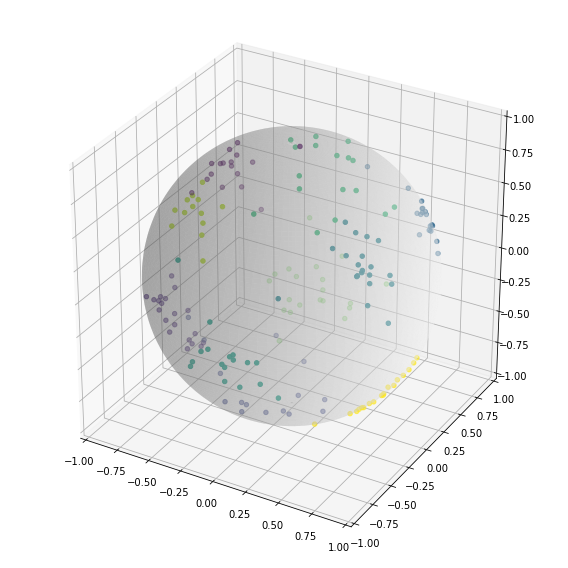

In [ ]:
# Visualize predicted embedding vector for each person faces
embeds, labels = get_embedding(device, model, train_loader)
plot_embedding(embeds, labels, save_filename=f'{SAVED_RESULTS_DIR}/embedding.jpg')

In [ ]:
m_history.result_summary()

Training best result: Accuracy: 100.00 at Epoch 407
Testing  best result: Accuracy: 92.00 at Epoch 479
Acuracy Gap: 8.00


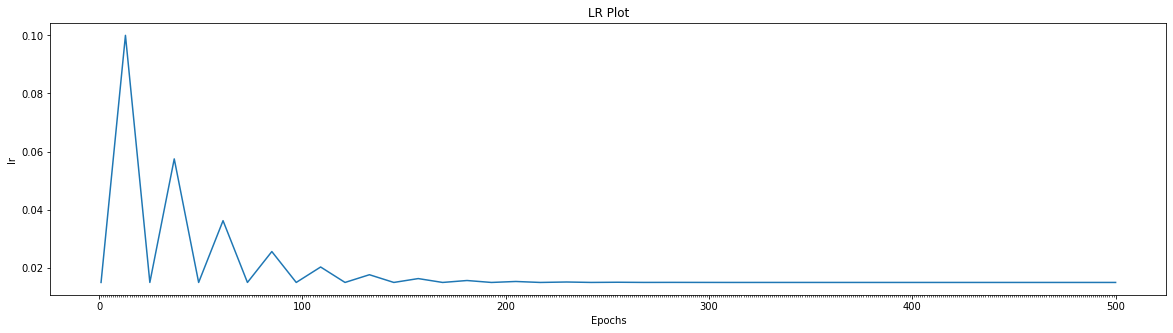

In [ ]:
m_history.plot_data_against_epoch(title="LR Plot", seriesname="lr", save_filename=f'{SAVED_RESULTS_DIR}/lr_plot.jpg')

In [ ]:
best_model = torch.load(f'{SAVED_MODELS_DIR}/bestmodel.pt')

In [ ]:
import utils.model_utils as mutils_fxn
testacc, testsize = mutils_fxn.get_test_accuracy(best_model, device, test_loader)
print(f'Accuracy of the model on the {testsize} test images: {testacc:0.2f}%')

Accuracy of the model on the 75 test images: 92.00%


In [ ]:
# Class based accuracy
mutils_fxn.get_class_based_accuracy(best_model, device, test_loader, class_names)

Accuracy of Akshay_Kumar : 100.00%
Accuracy of Amitabh_Bachchan : 60.00%
Accuracy of Amrish_Puri : 100.00%
Accuracy of Anil_Kapoor : 100.00%
Accuracy of Kajol : 100.00%
Accuracy of Katrina_Kaif : 100.00%
Accuracy of Madhuri_Dixit : 62.50%
Accuracy of Rajesh_Khanna : 100.00%
Accuracy of Shilpa_Shetty : 100.00%
Accuracy of Vinod_Khanna : 85.71%


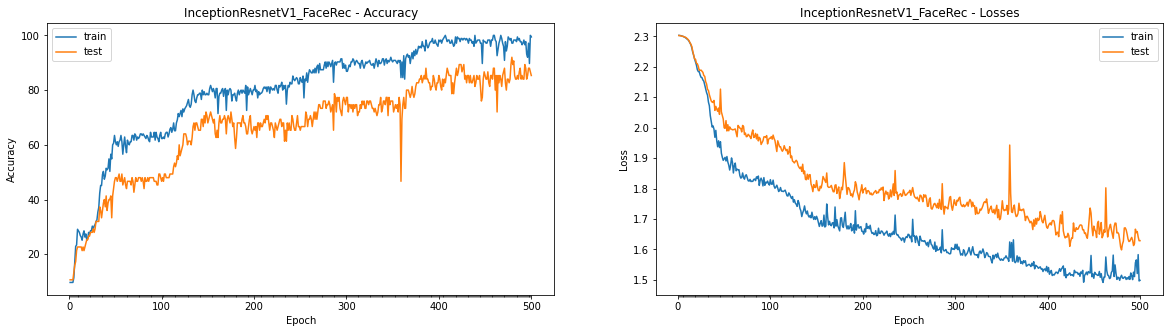

In [ ]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename=f'{PLOT_DIR}/model_history.jpg')